# Machine Learning

Este trabajo va a consistir en la limpieza y análisis de unos datos dados, para posteriormente proceder a analizar el agrupamiento de los datos y encontrar el mejor a través de diferentes técnicas.

In [39]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FixedLocator, FixedFormatter

import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score, silhouette_samples

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

from sklearn.pipeline import make_pipeline

### 1. PREPROCESSING

Lo primero que haremos en esta fase será leer el documento, además creamos una copia de seguridad antes de empezar con el proceso del tratamiento de los datos, este paso es importante para poder retomar el caso desde el principio en caso de que encontremos problemas a lo largo del trabajo.

Tras la importación de los datos empezaremos haciendo un estudio de estos para ver con que trabajamos y como podemos manejarlo, como por ejemplo que deberíamos limpiar.

--------- 1.1 ANÁLISIS DATOS -------------------------------------------------------------------------------------------

In [2]:
# pandas carga los datos como un DataFrame
data_or = pd.read_csv("data-even.csv")

# tomamos una copia de los datos originales sobre la que realizaremos el preprocesamiento
data = data_or.copy()

#Observamos las columnas de nuestro csv
print(data.head()) 

   Age   Education  EducationNum        MaritalStatus    Relationship Gender  \
0   39   Bachelors            13        Never-married   Not-in-family   Male   
1   50   Bachelors            13   Married-civ-spouse         Husband   Male   
2   52     HS-grad             9   Married-civ-spouse         Husband   Male   
3   30   Bachelors            13   Married-civ-spouse         Husband   Male   
4   25     HS-grad             9        Never-married       Own-child   Male   

   CapitalGain  HoursPerWeek  
0         2174            40  
1            0            13  
2            0            45  
3            0            40  
4            0            35  


Observamos que, efectivamente, el csv cuenta con datos compuestos por 8 características, las cuales serán objeto de estudio para la formación de los clusters, pues se trata de encontrar similitudes entre los distintos datos en dichas variables.

Una vez leidos los datos, procedemos a realizar un estudio básico de las variables que nos encontramos.

In [3]:
print("Shape:", data.shape)
print("\nColumnas:")
print(data.columns.tolist())

print("\nInfo:")
print(data.info())

Shape: (9865, 8)

Columnas:
['Age', 'Education', 'EducationNum', 'MaritalStatus', 'Relationship', 'Gender', 'CapitalGain', 'HoursPerWeek']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9865 entries, 0 to 9864
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Age            9865 non-null   int64 
 1   Education      9865 non-null   object
 2   EducationNum   9865 non-null   int64 
 3   MaritalStatus  9865 non-null   object
 4   Relationship   9865 non-null   object
 5   Gender         9865 non-null   object
 6   CapitalGain    9865 non-null   int64 
 7   HoursPerWeek   9865 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 616.7+ KB
None


Primeramente vemos que contamos con 9.865 instancias, en este caso individuos, y las 8 columnas mencionadas.

Como vemos, tenemos datos de diferentes tipos, tenemos tanto del tipo object, es decir, son datos categóricos donde los valores que toman son un string correspondiente a una categoría de un número finito de opciones, como del tipo enteros de 64 bits, datos númericos.

Por lo tanto, a la hora de limpiar tendremos que buscar una solución para ello, pues es necesario para trabajar sobre los valores que sean todos númericos.

--------- 1.2 PREPARACIÓN DE DATOS -------------------------------------------------------------------------------------

Antes del procesado de los datos es necesario prepararlos, es decir, limpiarlos para así mejorar su calidad y dejarlos listos para su transformación.

A continuación se seguirá el siguiente procedimiento de preparación:
- limpieza de inconsistencias en el formato
- detección de datos vacíos o inválidos (missing data)
- manejo de datos vacíos (eliminación o imputación, que imputación realizar?)
- eliminación de duplicados
- detección y manejo de datos atípicos tras análisis exploratorio
- búsqueda de correlaciones (variables redundantes)

1.2.1 Estandarización de Formato

El objetivo es resolver cualquier inconsistencia o error respecto al formato de los datos, de manera que estos queden estandarizados y puedan realizarse las transformaciones correctamente, ya que transformadores como OneHotCoder o gráficos que se basan en conteos y estadísticas pueden contener errores.

De primeras, los datos del csv parecen muy bien organizados y estructurados, hay un uso consistente de mayúsculas en los strings, así como la falta de espacios en estos. Sin embargo, para asegurar realizaremos una limpieza mínima de espacios y columnas.

In [4]:
# eliminado de espacios

# en nombres de las columnas
data.columns = data.columns.str.strip()       # quita espacios al inicio/fin
data.columns = data.columns.str.replace(' ', '')  # quita espacios internos

# en valores de tipo string del dataset
data = data.map(lambda x: x.strip() if isinstance(x, str) else x)
data = data.map(lambda x: x.replace(' ', '') if isinstance(x, str) else x)

In [5]:
# búsqueda de inconsistencia en strings
cols_string = data.select_dtypes(include='object').columns

for columna in cols_string:
    print(f"\nValores únicos en {columna}:")
    print(data[columna].unique())


Valores únicos en Education:
['Bachelors' 'HS-grad' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' '10th' 'Doctorate' '1st-4th' 'Preschool' '11th'
 '12th' '5th-6th' 'Prof-school']

Valores únicos en MaritalStatus:
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Widowed' 'Married-AF-spouse']

Valores únicos en Relationship:
['Not-in-family' 'Husband' 'Own-child' 'Unmarried' 'Wife' 'Other-relative']

Valores únicos en Gender:
['Male' 'Female']


Vemos que en los valores únicos de cada columna no hay inconsistencias por escritura (como "MALE", "male", "Male", etc.), por tanto no es necesario realizar ninguna limpieza en este aspecto.

Como último, buscaremos posibles datos numéricos erróneos, como datos que no se ajustan al rango adecuado para su campo (valores negativos o excesivamente grandes).

In [6]:
max_week_hours = 168
max_age = 120

cols_int = data.select_dtypes(include='int64').columns

for columna in cols_int:
    print(f"\nValores negativos en {columna}:")
    print(data[data[columna] < 0])
    if columna == "Age":
        print(f"\nValores que exceden el máximo en {columna}:")
        print(data[data[columna] > max_age])
    elif columna == "HoursPerWeek":
        print(f"\nValores que exceden el máximo en {columna}:")
        print(data[data[columna] > max_week_hours])



Valores negativos en Age:
Empty DataFrame
Columns: [Age, Education, EducationNum, MaritalStatus, Relationship, Gender, CapitalGain, HoursPerWeek]
Index: []

Valores que exceden el máximo en Age:
Empty DataFrame
Columns: [Age, Education, EducationNum, MaritalStatus, Relationship, Gender, CapitalGain, HoursPerWeek]
Index: []

Valores negativos en EducationNum:
Empty DataFrame
Columns: [Age, Education, EducationNum, MaritalStatus, Relationship, Gender, CapitalGain, HoursPerWeek]
Index: []

Valores negativos en CapitalGain:
Empty DataFrame
Columns: [Age, Education, EducationNum, MaritalStatus, Relationship, Gender, CapitalGain, HoursPerWeek]
Index: []

Valores negativos en HoursPerWeek:
Empty DataFrame
Columns: [Age, Education, EducationNum, MaritalStatus, Relationship, Gender, CapitalGain, HoursPerWeek]
Index: []

Valores que exceden el máximo en HoursPerWeek:
Empty DataFrame
Columns: [Age, Education, EducationNum, MaritalStatus, Relationship, Gender, CapitalGain, HoursPerWeek]
Index: []

Vemos que no hay valores inconsistentes respecto a los criterios marcados, por tanto, no será necesaria la limpieza para los datos numéricos. Se da por finalizada la estandarización del formato.

1.2.2 Missing Data

La gran mayoría de los estimadores de sklearn no son capaces de manejar datos faltantes, por tanto debemos ver si existen estos en nuestras observaciones y, o bien eliminarlos, o imputarlos.

Ahora buscamos el número de filas con missing data, esto son tanto valores con Null o NaN, o simplemente que no haya nada escrito (vacío).

In [7]:
#Revisar valores faltantes por columna
missing_data_count = data.isnull().sum()
print("Número de filas con datos faltantes por columna:")
print(missing_data_count)

#Contar filas con al menos un valor faltante
total_missing_rows = data.isnull().any(axis=1).sum()
print("\nNúmero total de filas con datos faltantes:", total_missing_rows)

Número de filas con datos faltantes por columna:
Age              0
Education        0
EducationNum     0
MaritalStatus    0
Relationship     0
Gender           0
CapitalGain      0
HoursPerWeek     0
dtype: int64

Número total de filas con datos faltantes: 0


In [8]:
empty_strings_count = (data == "").sum()
print("Número de celdas vacías ('') por columna:")
print(empty_strings_count)


Número de celdas vacías ('') por columna:
Age              0
Education        0
EducationNum     0
MaritalStatus    0
Relationship     0
Gender           0
CapitalGain      0
HoursPerWeek     0
dtype: int64


Por suerte, no nos encontramos con valores faltantes lo que simplifica mucho la limpieza, ya que no tendremos que plantearnos que método usar para rellenar o reemplazar esos espacios.

1.2.3 Observaciones Duplicadas

*En este caso se nos pueden presentar muchas filas que digan que son duplicadas, pero pueden ser personas diferentes que han coincidido que tienen los mismos datos.*

De todas maneras eliminaremos los duplicados ya que la eliminación de filas duplicadas en el dataset no altera los resultados del clustering jerárquico ni la estructura del dendrograma, ya que los duplicados representan observaciones idénticas en todas las variables y, por lo tanto, no aportan información adicional sobre las distancias entre los puntos. De esta manera, su eliminación implicaría mayor eficiencia y reducción del coste computacional al manejar un número menos de instancias.

In [9]:
duplicate_rows = data[data.duplicated()]
print("Número de filas duplicadas:", len(duplicate_rows))

# Mostrar duplicados si existen
duplicate_mask = data.duplicated(keep= False)  # keep=False marca todas las ocurrencias
display(data[duplicate_mask].sort_values(list(data.columns)))

Número de filas duplicadas: 2810


Age    Education  EducationNum       MaritalStatus Relationship  Gender  \
1544   17         10th             6       Never-married    Own-child  Female   
9625   17         10th             6       Never-married    Own-child  Female   
545    17         10th             6       Never-married    Own-child  Female   
5079   17         10th             6       Never-married    Own-child  Female   
7525   17         10th             6       Never-married    Own-child  Female   
...   ...          ...           ...                 ...          ...     ...   
7299   79      HS-grad             9  Married-civ-spouse      Husband    Male   
5623   80      HS-grad             9  Married-civ-spouse      Husband    Male   
6400   80      HS-grad             9  Married-civ-spouse      Husband    Male   
358    88  Prof-school            15  Married-civ-spouse      Husband    Male   
6669   88  Prof-school            15  Married-civ-spouse      Husband    Male   

      CapitalGain  HoursPerWeek  
1544            0            15  
9625            0            15  
545             0            20  
5079            0            20  
7525            0            20  
...           ...           ...  
7299            0            40  
5623            0             8  
6400            0             8  
358             0            40  
6669            0            40  

[3953 rows x 8 columns]

Se han encontrado 2810 observaciones duplicadas en total, sin incluir las primeras ocurrencias. Esto es un número bastante elevado por lo que la eliminación de dichos duplicados procede, pues reducirá el coste computacional del transformado de datos y el posterior estudios de clustering. Esto se debe a que esta limpieza reduce redundancia, pues los duplicados no aportan informacion nueva al análisis, y optimiza el cálculo del clustering sin afectar la estructura ni los resultados del análisis.

In [10]:
print("Tamaño del dataset antes de drop_duplicates:", data.shape)
data = data.drop_duplicates()
print("Tamaño después de drop_duplicates:", data.shape)

Tamaño del dataset antes de drop_duplicates: (9865, 8)
Tamaño después de drop_duplicates: (7055, 8)


Proseguiremos la limpieza ahora con el nuevo set de datos reducido.

1.2.4 Valores Atípicos.

La detección y eliminación de los valores atípicos es crucial ya que estos pueden afectar significativamente a los estimadores y clusters de sklearn. En este caso entenedemos que solo tiene sentido trabajar sobre las características de naturaleza numérica.

Como primer método para la detección de valores atípicos usaremos el rango intercuartílico sobre las variables numéricas.

In [11]:
# Select only numerical columns
numerical_data = data.select_dtypes(include='int64')

numerical_stats = numerical_data.describe()

# calculamos e incluimos el rango intercuartílico en el resumen estadístico
Q1 = numerical_stats.loc['25%']
Q3 = numerical_stats.loc['75%']
IQR = Q3 - Q1
numerical_stats.loc['IQR'] = IQR

numerical_stats

Age  EducationNum   CapitalGain  HoursPerWeek
count  7055.000000   7055.000000   7055.000000   7055.000000
mean     43.730971     10.547555   2067.226223     40.532814
std      15.001462      2.878599  10811.456752     16.246708
min      17.000000      1.000000      0.000000      1.000000
25%      32.000000      9.000000      0.000000     35.000000
50%      43.000000     10.000000      0.000000     40.000000
75%      54.000000     13.000000      0.000000     50.000000
max      90.000000     16.000000  99999.000000     99.000000
IQR      22.000000      4.000000      0.000000     15.000000

Resumen:

*Age:* rango de 17 a 90 años, media ~43.73.

*EducationNum:* rango de 1 a 16 años, media ~10.55.

*CapitalGain:* rango de 0 a 99999 dolares, media ~2067.23.

*HoursPerWeek:* rango de 1 a 99 horas, media ~40.53.

Observaciones interesantes:

*CapitalGain:* es sin duda la característica que más llama la atención. Presenta una distribución extremadamente asimétrica, con muchos ceros y valores extremos hasta 99,999$. Observamos que el rango intercuartilico es 0, es decir, el cuerpo (el 50% de los datos centrales) se compone de un único valor, luego los datos están extremadamente compactos. Además vemos que la mediana es 0, así como Q1 y Q3, nos está dando a entender que la inmensa mayoría de valores para esta variable es 0.

Por otro lado la media es 2067.23, por lo tanto vemos que no es nada representativa, esto nos da indicios de que esta siendo afectada enormemente por datos atípicos. No obstante, no podemos simplemente interpretar que los datos elevados dentro de dicha característica sean anomalías, lo más probable es que sean correctos y simplemente es muy bajo el número de personas que obtuvieron beneficios por la venta de activos.


Ahora veremos un estudio gráfico a través de histogramas y boxplots individuales.


Columnas numéricas detectadas: ['Age', 'EducationNum', 'CapitalGain', 'HoursPerWeek']
Age: 16 valores atípicos (0.23%)
EducationNum: 42 valores atípicos (0.60%)
CapitalGain: 953 valores atípicos (13.51%)
HoursPerWeek: 641 valores atípicos (9.09%)


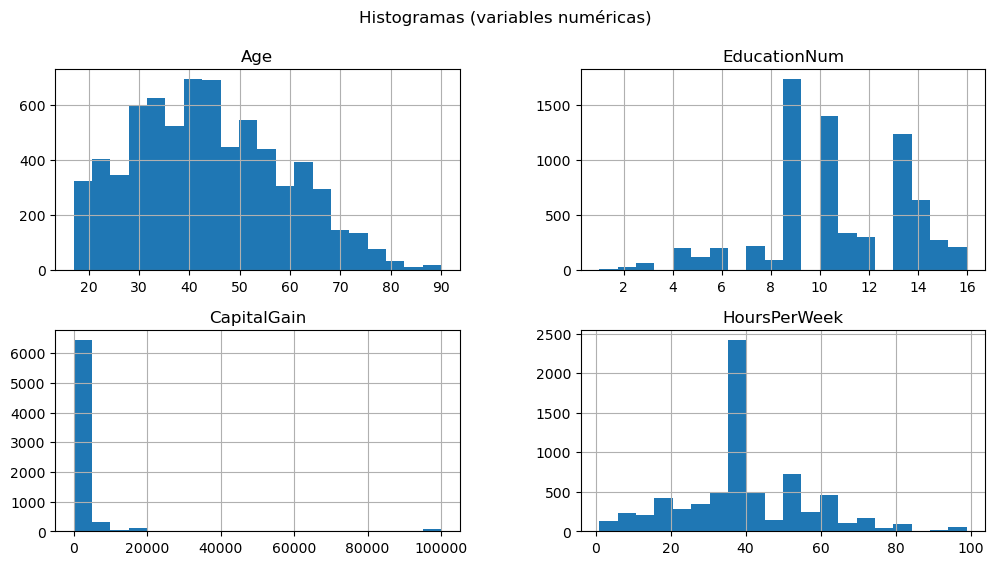

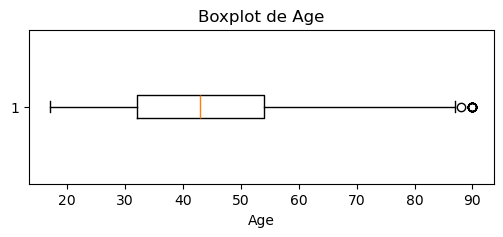

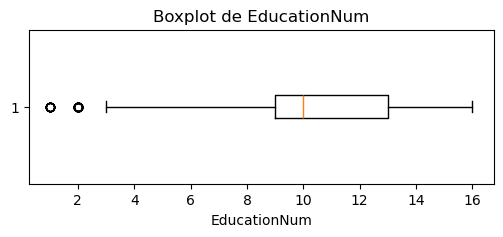

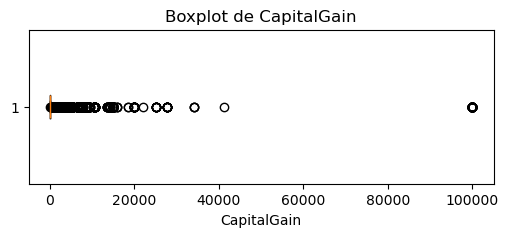

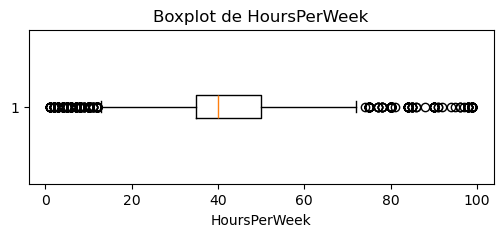

In [12]:
num_cols = data.select_dtypes(include=['int64']).columns.tolist()
print("\nColumnas numéricas detectadas:", num_cols)

# conteo de valores atípicos
for col in num_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Filtrar valores atípicos
    outliers = data[(data[col] < lower) | (data[col] > upper)]
    n_outliers = len(outliers)
    pct_outliers = n_outliers / len(data) * 100

    print(f"{col}: {n_outliers} valores atípicos ({pct_outliers:.2f}%)")

# herramientas gráficas para la detección de valores atípicos
if len(num_cols) > 0:
    # Histogramas
    data[num_cols].hist(bins=20, figsize=(12,6))
    plt.suptitle("Histogramas (variables numéricas)")
    plt.show()

    # Boxplots individuales
    for c in num_cols:
        plt.figure(figsize=(6,2))
        plt.boxplot(data[c].dropna(), vert=False) 
        plt.title(f"Boxplot de {c}")
        plt.xlabel(c)
        plt.show()



En los boxplots anteriores, los puntos marcados como circulos representan los valores atípicos calculados mediante el rango intercuatílico de los datos.

Observaciones:

*Age:* El boxplot para la característica de edad muestra una distribución muy simétrica, y muy pocos valores atípicos detectados por el IQR. 

*EducationNum:* Se muestra un rango relativamente estrecho, entre aproximadamente 9 y 14. Se pueden ver pocos puntos aislados por debajo de 3 años, considerados outliers según este estudio estadístico.

*CapitalGain:* Como era de esperar, tiene un elevado número de valores atípicos (outliers). Vemos una distribución extremadamente compacta, hasta el punto en el que parece que cualquier valor distinto a 0 fuese un valor atípico. A mayores tiene un rango total muy amplio, llegando a valores extremos de 99.999$, por tanto se trata de una distribucion fuertemente asimétrica.  Se trata de una variable dispersa (muchos 0s).

*HoursPerWeek:* Están relativamente distribuidos de forma normal. Cuenta con algunos bastantes valores atípicos a ambos lados de la distribución, en el extremo izquierdo puede deberse a trabajos a tiempo parcial mientras que al extremo derecho hay valores que sí rozan el irrealismo, como individuos que trabajan 99 horas a la semana, lo que significaría trabajar más de 4 días completos.

<font color="red">tiene pocos valores únicos, consistente con su carácter ordinal, ya que refleja niveles educativos con un orden natural</font>

Podemos a mayores calcular el valor z, no obstante, tenemos en cuenta que asume distribuciones simétricas pues se basa únicamente en la media y la desviación típica las cuales son muy sensibles a los valores atípicos.

In [13]:
from scipy import stats
z_scores = np.abs(stats.zscore(data[num_cols]))
print((z_scores > 3).sum(axis=0))

Age             15
EducationNum    10
CapitalGain     78
HoursPerWeek    74
dtype: int64


Efectivamente vemos que, sobretodo para las distribuciones altamente sesgadas, el número de valores atípicos identificados es significativamente menor, por tanto decidimos que esta medida no es adecuada para nuestro data set y nos basaremos en el estudio del rango intercuartílico.

Este estudio estadístico nos ha permitido identificar valores atípicos para las variables numéricas, no obstante, no por ello quiere decir que sean valores anómalos que deban ser eliminados. Si bien pueden tener un efecto grande sobre el calculo de clusterings, si estos son datos reales pueden representar grupos minoritarios que tendrán un gran valor interpretativo y contribuyen a la representación de la realidad, lo que sí debería verse reflejado el las agrupaciones.

Por tanto, consideramos que simplemente eliminarlos del conjunto de datos sería un error y modificaría una realidad que muestra gran variabilidad y asímetría que debe ser tenida en cuenta. Podemos interpretar que la gran mayoría de estos no son errores sino datos reales. A mayores debemos tener en cuenta que algunos algoritmos de clustering como DBSCAN ya detectan ruido de por sí.

Una solución a la distribución compacta de la variable Capital Gains es aplicar una transformación logarítmica.

En este caso de estudio Capitalgain tiene valores muy extremos y muchos ceros → distribución muy sesgada.

El log reduce el efecto de los valores extremos y hace que la variable sea más homogénea, evitando que domine el clustering. Como presentaba una gran concentración de valores en cero y algunos valores extremadamente altos, 
para reducir esta asimetría y evitar que los valores extremos dominen el análisis, se aplicó la transformación logarítmica que permite manejar ceros de forma segura.

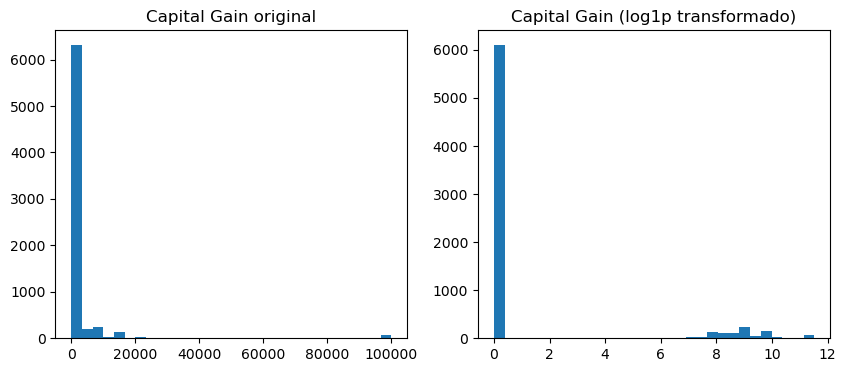

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(data['CapitalGain'], bins=30)
plt.title("Capital Gain original")

data['CapitalGainLog'] = np.log1p(data['CapitalGain']) # usamos log1p para evitar errores con logaritmos de 0
data = data.drop(columns=['CapitalGain'])
# data_cleaned = data

plt.subplot(1,2,2)
plt.hist(data['CapitalGainLog'], bins=30)
plt.title("Capital Gain (log1p transformado)")

plt.show()

Vemos que, aún manteniendose la distribución asimétrica, debida a que la absoluta mayoría de los datos son 0, el rango es mucho menor y por tanto se ha logrado adquirir una distribución más adecuada para el alcance de dicha característica.

1.2.5 Correlaciones entre Variables

Por último realizaremos un estudio de la correlación entre variables numéricas, para poder detectar si existe redundancia en algunas de estas y debe eliminarse. Es decir, si dos variables mantienen una dependencia fuerte entre ellas, aportan información muy similar al estudio, y por tanto puede decidirse que una es innecesaria.

Para calcular dichas correlaciones usaremos un heatmap de la librería seaborn. Lo haremos solo sobre las variables numéricas ya que nos basaremos en la correlación de Pearson, la cual requiere valores numéricos.

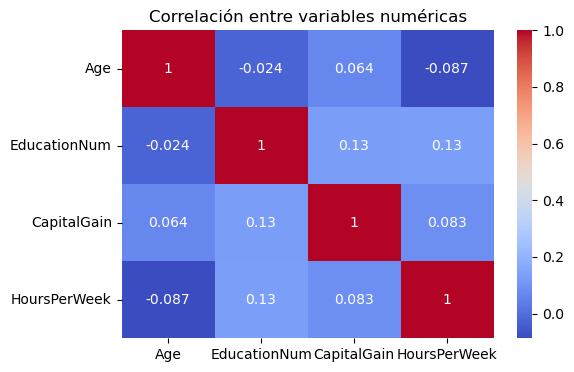

In [15]:
plt.figure(figsize=(6,4))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlación entre variables numéricas")
plt.show()

En los resultados vemos que todos los valores presentan una correlación bastante débil (todas por muy próximas a 0), asi que consideramos que todas las variables numéricas presentadas tienen su importancia y no eliminaremos ninguna por ahora.

Más allá de las características numéricas, también puede existir una correlación fuerte entre características de distinto tipo de datos. En este caso nos referimos a la variable "Education" de carácter categórico y "EducationNum", numérico y estudiado anteriormente, sabiendo que esta última se considera la representación numérica de la primera. 

Se entiende entonces que, si pasamos Education a una codificación ordinal los resultados serían prácticamente identicos a los de EducationNum, a nivel matemático (no necesariamente los mismos valores).

Para poder confirmar esto antes de decidir que Education es redundante y debe ser eliminada, usaremos el conversor a valores ordinale (OrdinalEncoder) sobre Education y calcularemos la correlación. Si bien el proceso de convetrir variable categoricas a numericas forma parte del siguiente paso (procesamiento), se realizará está ahora pues la eliminación de redundancias debe llevarse acabo en la limpieza.

In [16]:
encoder = OrdinalEncoder()
data['EducationOrd'] = encoder.fit_transform(data[['Education']]) # el set a fit y transformar es el mismo

# Calculamos la correlación con EducationNum
corr = data[['EducationOrd', 'EducationNum']].corr().iloc[0, 1]
print(f"Correlación education vs education_num: {corr:.3f}")

Correlación education vs education_num: 0.383


Vemos que nos devuelve una correlación de 0.383, lo cual no indica una correlación fuerte entre ambas variables, de hecho se interpretaría como débil. Sin embargo, sabemos por la naturaleza de las características que una es la representación de la otra.

Para entender este comportamiento debemos entender como funciona OrdinalEncoder.

In [17]:
cat = data['Education'].unique()
ord = data['EducationOrd'].unique()

for i in range(len(cat)):
    print(f"{cat[i]} = {ord[i]}")

Bachelors = 9.0
HS-grad = 11.0
Masters = 12.0
9th = 6.0
Some-college = 15.0
Assoc-acdm = 7.0
Assoc-voc = 8.0
7th-8th = 5.0
10th = 0.0
Doctorate = 10.0
1st-4th = 3.0
Preschool = 13.0
11th = 1.0
12th = 2.0
5th-6th = 4.0
Prof-school = 14.0


Vemos que los valores ordinales asignados a cada categoría no tienen sentido con su verdadero ordena natural, la razón es que probablemente las categorías de Education no vengan ordenadas. Se especificará entonces el orden a usar en el encoder.

In [18]:
order = ['Preschool','1st-4th','5th-6th','7th-8th','9th','10th','11th','12th','HS-grad','Some-college','Assoc-acdm','Assoc-voc','Bachelors','Masters','Prof-school','Doctorate'] 

encoder = OrdinalEncoder(categories=[order])
data['EducationOrd'] = encoder.fit_transform(data[['Education']]) # el set a fit y transformar es el mismo

# Calculamos la correlación con EducationNum
corr = data[['EducationOrd', 'EducationNum']].corr().iloc[0, 1]
print(f"Correlación education vs education_num: {corr:.3f}")

# Si la correlación es muy alta (≈ 1.0), eliminar 'education'
if corr > 0.9:
   data = data.drop(columns=['Education'])

# Eliminar la codificación temporal (ya no la necesitas)
data = data.drop(columns=['EducationOrd'])

Correlación education vs education_num: 0.995


Como la correlación es ahora de 0.995, se ha eliminado la columna de Education por redundancia.

--------- 1.3 PROCESAMIENTO DE DATOS -----------------------------------------------------------------------------------

Una vez realizado la limpieza podemos pasar al procesamiento de datos. En este caso consistirá del escalado de estos seguidos de la conversión de valores categóricos a numéricos. Para este paso crearemos un pipeline con el objetivo de mantener el proceso ordenado y reproducible, además, para las transformaciones de tipos de datos usaremos ColumnTransformer.

1.3.1 Escalar Variables

En clustering, como se calculan disimilitudes entre puntos, si una variable tiene un rango mucho mayor que otra, dominará la distancia u otra medidade de disimilitud y distorsionará los resultados. Cuando escalamos buscamos que todas las variables tengan el mismo peso. Escalar las variables a media 0 y desviación estándar 1 iguala su escala, asegurando que todas contribuyan de manera equilibrada al clustering.

Existen varios tipos de escalados, por lo que evaluaremos y compararemos estos, justificando cual es el más adecuado por su efecto en los datos y conceptualmente.

In [19]:
# división de características por tipo
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
cat_cols = data.select_dtypes(include=['object']).columns

print(num_cols)
print(cat_cols)

Index(['Age', 'EducationNum', 'HoursPerWeek', 'CapitalGainLog'], dtype='object')
Index(['MaritalStatus', 'Relationship', 'Gender'], dtype='object')


Podemos considerar dos tipos de escalares adecuados para nuestros datos concretos, el StandardScaler, que se fija en escalar los datos para que la media sea 0 y la desviación típica sea 1, o el RobustScaler, que es muy similar conceptualmente pero es robusto antes los datos atípicos, ya que no los hemos eliminado por considerar que son datos reales y relevantes.

Realizamos una comparación del efecto que tienen estos escalados sobre los datos con boxplots.

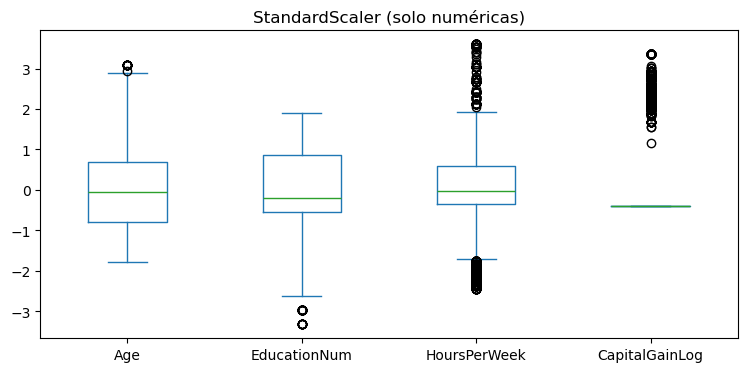

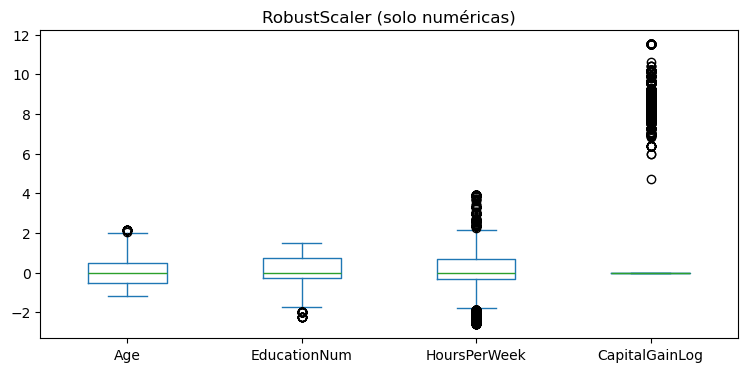

In [20]:
# Dataset numérico
num_data = data[num_cols]

# Crear escaladores
scalers = {
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler()
}

# Aplicar y mostrar boxplots comparativos
for name, scaler in scalers.items():
    scaled = scaler.fit_transform(num_data)
    scaled_df = pd.DataFrame(scaled, columns=num_cols)
    scaled_df.plot(kind='box', figsize=(9,4), title=f"{name} (solo numéricas)")
    plt.show()

Los resultados son interesantes, vemos que con ambos escalados todas las variables numéricas menos CapitalGain parecen ser escaladas de manera muy similar, por supuesto la media se mantiene en 0 y vemos que el resto de sus distribuciones se mantiene bastante constantes, con la diferencia de que con RobustScaler se compactan un poco más por usar el rango intercuartílico, sin embargo no es un efecto exagerado.

La gran diferencia está de nuevo en CapitalGain, vemos en estos resultados que RobustScaler parece ser demasiado agresivo para nuestros datos ya transformados por aplicación de logaritmos. Al usar este ecalado los datos extremos de esta variable dominarían nuestros clusterings. Por tanto, a pesar de que sí hemos mantenido los valores atípicos, el escalado más adecuado resulta ser StandarScaler.

<font color="red">Ignorar esta sección (incluir que se intento/considero en la memoria y no dio los resultados esperados?)</font>

1.3.1.1 Descomposición de Dos Características

In [21]:
zeros = data[data['CapitalGainLog'] == 0]
zeros_num = len(zeros)
pct_zeros = zeros_num / len(data) * 100
print(f"{pct_zeros:.2f}")

86.49


Podemos observar, que la variable CapitalGain es una variable complicada, debido a que esta se compone de "datos con exceso de ceros", con hasta un 86.49% de 0s. Esto tiene graves implicaciones sobre el clustering, ya que, estamos considerando a las personas que no tienen ganancias y las que sí como un único conjunto, e incluyendo en esta variable continua la cantidad ganada de los que sí tienen ganancia. A la hora de realizarse el clustering, la inmensa cantidad de 0s creará un grupo extremadamente compacto compuesto por todas aquellas personas que no tuvieron ganancias y los pocos valores positivos que permanecen se verán extremadamente lejos de estos, por tanto es posible que los diferentes modelos de clustering los consideren valores atípicos y no los tengan en cuenta o que se den agrupaciones irreales.

Una posible solución ha este problema es la descomposición de CapitalGain en dos características, una binaria indicando si el individuo tiene gains o no, y otra con los valores de dichos gains (aplicando logaritmos). De esta manera a la hora del clustering se detectará esta distincción mejorando el comportamiento de los modelos y la interpretabilidad.

Esta solución implica un aumento de la dimensionalidad pues estamos metiendo una variable adicional, por tanto llevaremos a cabo un pequeño estudio sobre el cálculo de KNN con 3 clusters, y su evaluación con silhoutte para observar si realmente hay una mejora y merece la pena aplicar esta estrategia al proyecto completo.

<font color="red">Hasta aqui</font>

1.3.2 Conversión de Categóricos a Numéricos

Tras el escalado de las variables numéricas, el siguiente y último paso del procesado sería la conversión de variables categóricas a numéricas ya que estas son necesarias para los modelos de clustering. Recordamos que la característica Education fue eliminada, por tanto las columnas categóricas restantes son:
- Gender
- MaritalStatus
- Relationship

A la hora de realizar la conversión tenemos varias opciones, OrdinalEncoder, OneHotEncoding o incluso nuestro propio encoder. Sin embargo, podemos rechazar de inmediato la idea de usar OrdinalEncoder ya que las tres variables en cuestión no son de naturaleza ordinal. El uso de este transformador implicaría que se consideren distancias irreales, pues se otorgaría un valor del 0 al K-1 (K siendo el número de categorías posibles) a valores que no tienen una diferencia en cuanto distancia si no que simplemente son distintos.

La variable de Gender es la más sencilla pues solo permite dos valores, por tanto, OneHotEncoding será perfectamente adecuado en este caso, no hay necesidad de modificar nada manualmente. Además sabemos que con la información de una de las columnas podemos concluir la de la segunda (redundancia), puediendo entonces eliminarla.

Las otras dos variables que no son numéricas son más complejas, vamos a ver cuantas posibilidades diferentes hay en cada columna.

In [21]:
categorical_cols = ['MaritalStatus', 'Relationship']

for col in categorical_cols:
    print(f"{col}: {data[col].nunique()} categorías")
    print(data[col].unique())
    print()

MaritalStatus: 7 categorías
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Widowed' 'Married-AF-spouse']

Relationship: 6 categorías
['Not-in-family' 'Husband' 'Own-child' 'Unmarried' 'Wife' 'Other-relative']



Para las variables categóricas MaritalStatus y Relationship, se optó nuevamente por utilizar One-Hot Encoding en lugar de una codificación personalizada o el uso de OrdinalEncoder. Esta decisión se fundamenta en que ambas variables son nominales, es decir, no poseen un orden natural entre sus categorías. One-Hot Encoding permite transformar cada categoría en una columna binaria independiente, preservando la independencia entre categorías y evitando que el algoritmo de clustering interprete un orden o distancia artificial.

A pesar de que lo más adecuado es la conversión con OneHotEncoder, debemos ser conscientes de sus desventajas. La mayor siendo que conllevo un aumento de dimensionalidad, que si bien podemos reducirlo minimamente eliminando las resultantes columnas redundantes, sigue habiendo aumento de dimensionalidad. No obstante esta desventaja no es lo suficiente pesada como para que decidamos no realizar esta conversión y, por ejemplo, eliminar al completo las variables no-numéricas.

Creamos un objeto ColumnTransformer para definir el procesamiento de las columnas numéricas (escalado) y de las categóricas (conversión a numéricas)

In [22]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),   # Escalar solo las numéricas
    ('cat', OneHotEncoder(drop='first'), cat_cols)  # Codificar solo las categóricas
])

<font color="red">Creamos el pipeline de momento solo para el preprocesamiento, luego lo cambiamos</font>

In [23]:
kmeans_pipe = make_pipeline(preprocessor)

In [26]:
X = data

# Creamos el pipeline SOLO con el preprocesador
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(preprocessor)

# Entrenamos y transformamos (sin clustering)
processed_data = pipe.fit_transform(X)

print("Forma original:", X.shape)
print("Forma transformada:", processed_data.shape)

Forma original: (7055, 7)
Forma transformada: (7055, 16)


Vemos que ahora hay 16 columnas, correspondientes a las nuevas creadas por OneHotEncoder.

Finalmente creamos el dataframe con los datos preprocesado a usar en el estudio de clustering.

In [27]:
# Obtener nombres
num_features = preprocessor.named_transformers_['num'].get_feature_names_out(num_cols)
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_features = np.concatenate([num_features, cat_features])

# Crear nuevo DataFrame
data_processed = pd.DataFrame(processed_data, columns=all_features, index=data.index)

# Resultado
print("Data procesada:", data_processed.shape)
display(data_processed.head())

Data procesada: (7055, 16)


Age  EducationNum  HoursPerWeek  CapitalGainLog  \
0 -0.315390      0.852018     -0.032797        2.108768   
1  0.417924      0.852018     -1.694790       -0.391832   
2  0.551254     -0.537645      0.274979       -0.391832   
3 -0.915374      0.852018     -0.032797       -0.391832   
4 -1.248698     -0.537645     -0.340574       -0.391832   

   MaritalStatus_Married-AF-spouse  MaritalStatus_Married-civ-spouse  \
0                              0.0                               0.0   
1                              0.0                               1.0   
2                              0.0                               1.0   
3                              0.0                               1.0   
4                              0.0                               0.0   

   MaritalStatus_Married-spouse-absent  MaritalStatus_Never-married  \
0                                  0.0                          1.0   
1                                  0.0                          0.0   
2                                  0.0                          0.0   
3                                  0.0                          0.0   
4                                  0.0                          1.0   

   MaritalStatus_Separated  MaritalStatus_Widowed  Relationship_Not-in-family  \
0                      0.0                    0.0                         1.0   
1                      0.0                    0.0                         0.0   
2                      0.0                    0.0                         0.0   
3                      0.0                    0.0                         0.0   
4                      0.0                    0.0                         0.0   

   Relationship_Other-relative  Relationship_Own-child  \
0                          0.0                     0.0   
1                          0.0                     0.0   
2                          0.0                     0.0   
3                          0.0                     0.0   
4                          0.0                     1.0   

   Relationship_Unmarried  Relationship_Wife  Gender_Male  
0                     0.0                0.0          1.0  
1                     0.0                0.0          1.0  
2                     0.0                0.0          1.0  
3                     0.0                0.0          1.0  
4                     0.0                0.0          1.0

<font color="red">Vale todo lo siguiente hasta el clustering no entiendo porque lo haces, en plan para que (lo quitaría)</font>

In [32]:
print(data_processed.std())

Age                                    1.000071
EducationNum                           1.000071
HoursPerWeek                           1.000071
CapitalGainLog                         1.000071
MaritalStatus_Married-AF-spouse        0.033657
MaritalStatus_Married-civ-spouse       0.499259
MaritalStatus_Married-spouse-absent    0.127178
MaritalStatus_Never-married            0.436288
MaritalStatus_Separated                0.191179
MaritalStatus_Widowed                  0.229642
Relationship_Not-in-family             0.446751
Relationship_Other-relative            0.165979
Relationship_Own-child                 0.315535
Relationship_Unmarried                 0.324553
Relationship_Wife                      0.258516
Gender_Male                            0.478867
dtype: float64


Visualizamos el resultado final una vez hemos realizado la limpieza.

In [ ]:
print(data_processed.dtypes)
print(data_processed.head())

Age                                    float64
EducationNum                           float64
HoursPerWeek                           float64
CapitalGainLog                         float64
MaritalStatus_Married-AF-spouse        float64
MaritalStatus_Married-civ-spouse       float64
MaritalStatus_Married-spouse-absent    float64
MaritalStatus_Never-married            float64
MaritalStatus_Separated                float64
MaritalStatus_Widowed                  float64
Relationship_Not-in-family             float64
Relationship_Other-relative            float64
Relationship_Own-child                 float64
Relationship_Unmarried                 float64
Relationship_Wife                      float64
Gender_Male                            float64
dtype: object
        Age  EducationNum  HoursPerWeek  CapitalGainLog  \
0 -0.315390      0.852018     -0.032797        2.108768   
1  0.417924      0.852018     -1.694790       -0.391832   
2  0.551254     -0.537645      0.274979       -0.391832  

In [ ]:
# Select only numerical columns
numerical_data = data.select_dtypes(include=['int64', 'float64', 'bool'])

numerical_stats = numerical_data.describe()

Q1 = numerical_stats.loc['25%']
Q3 = numerical_stats.loc['75%']
IQR = Q3 - Q1
numerical_stats.loc['IQR'] = IQR

numerical_stats

Age  EducationNum  HoursPerWeek  Gender_ Male  \
count  7.055000e+03  7.055000e+03  7.055000e+03  7.055000e+03   
mean  -8.057182e-17  1.299221e-16  1.724741e-16 -1.291667e-16   
std    1.000071e+00  1.000071e+00  1.000071e+00  1.000071e+00   
min   -1.782017e+00 -3.316972e+00 -2.433454e+00 -1.344812e+00   
25%   -7.820439e-01 -5.376451e-01 -3.405740e-01 -1.344812e+00   
50%   -4.873010e-02 -1.902292e-01 -3.279750e-02  7.435984e-01   
75%    6.845837e-01  8.520182e-01  5.827555e-01  7.435984e-01   
max    3.084520e+00  1.894266e+00  3.598965e+00  7.435984e-01   
IQR    1.466628e+00  1.389663e+00  9.233294e-01  2.088410e+00   

       MaritalStatus_ Married-AF-spouse  MaritalStatus_ Married-civ-spouse  \
count                      8.747000e+03                       8.747000e+03   
mean                       1.340340e-17                      -3.899171e-17   
std                        1.000057e+00                       1.000057e+00   
min                       -3.025618e-02                      -7.842382e-01   
25%                       -3.025618e-02                      -7.842382e-01   
50%                       -3.025618e-02                      -7.842382e-01   
75%                       -3.025618e-02                       1.275123e+00   
max                        3.305110e+01                       1.275123e+00   
IQR                        0.000000e+00                       2.059361e+00   

       MaritalStatus_ Married-spouse-absent  MaritalStatus_ Never-married  \
count                          8.747000e+03                  8.747000e+03   
mean                           3.574240e-17                  6.498619e-17   
std                            1.000057e+00                  1.000057e+00   
min                           -1.159307e-01                 -5.097353e-01   
25%                           -1.159307e-01                 -5.097353e-01   
50%                           -1.159307e-01                 -5.097353e-01   
75%                           -1.159307e-01                 -5.097353e-01   
max                            8.625843e+00                  1.961803e+00   
IQR                            0.000000e+00                  0.000000e+00   

       MaritalStatus_ Separated  MaritalStatus_ Widowed  \
count              8.747000e+03            8.747000e+03   
mean              -4.061637e-17           -6.173688e-17   
std                1.000057e+00            1.000057e+00   
min               -1.777850e-01           -2.171835e-01   
25%               -1.777850e-01           -2.171835e-01   
50%               -1.777850e-01           -2.171835e-01   
75%               -1.777850e-01           -2.171835e-01   
max                5.624772e+00            4.604401e+00   
IQR                0.000000e+00            0.000000e+00   

       Relationship_ Not-in-family  Relationship_ Other-relative  \
count                 8.747000e+03                  8.747000e+03   
mean                 -1.169751e-16                 -4.549033e-17   
std                   1.000057e+00                  1.000057e+00   
min                  -5.343850e-01                 -1.529707e-01   
25%                  -5.343850e-01                 -1.529707e-01   
50%                  -5.343850e-01                 -1.529707e-01   
75%                  -5.343850e-01                 -1.529707e-01   
max                   1.871310e+00                  6.537201e+00   
IQR                   0.000000e+00                  0.000000e+00   

       Relationship_ Own-child  Relationship_ Unmarried  Relationship_ Wife  \
count             8.747000e+03             8.747000e+03        8.747000e+03   
mean             -1.949586e-17            -6.173688e-17        1.072272e-16   
std               1.000057e+00             1.000057e+00        1.000057e+00   
min              -3.153123e-01            -3.267949e-01       -2.483102e-01   
25%              -3.153123e-01            -3.267949e-01       -2.483102e-01   
50%              -3.153123e-01            -3.267949e-01       -2.48

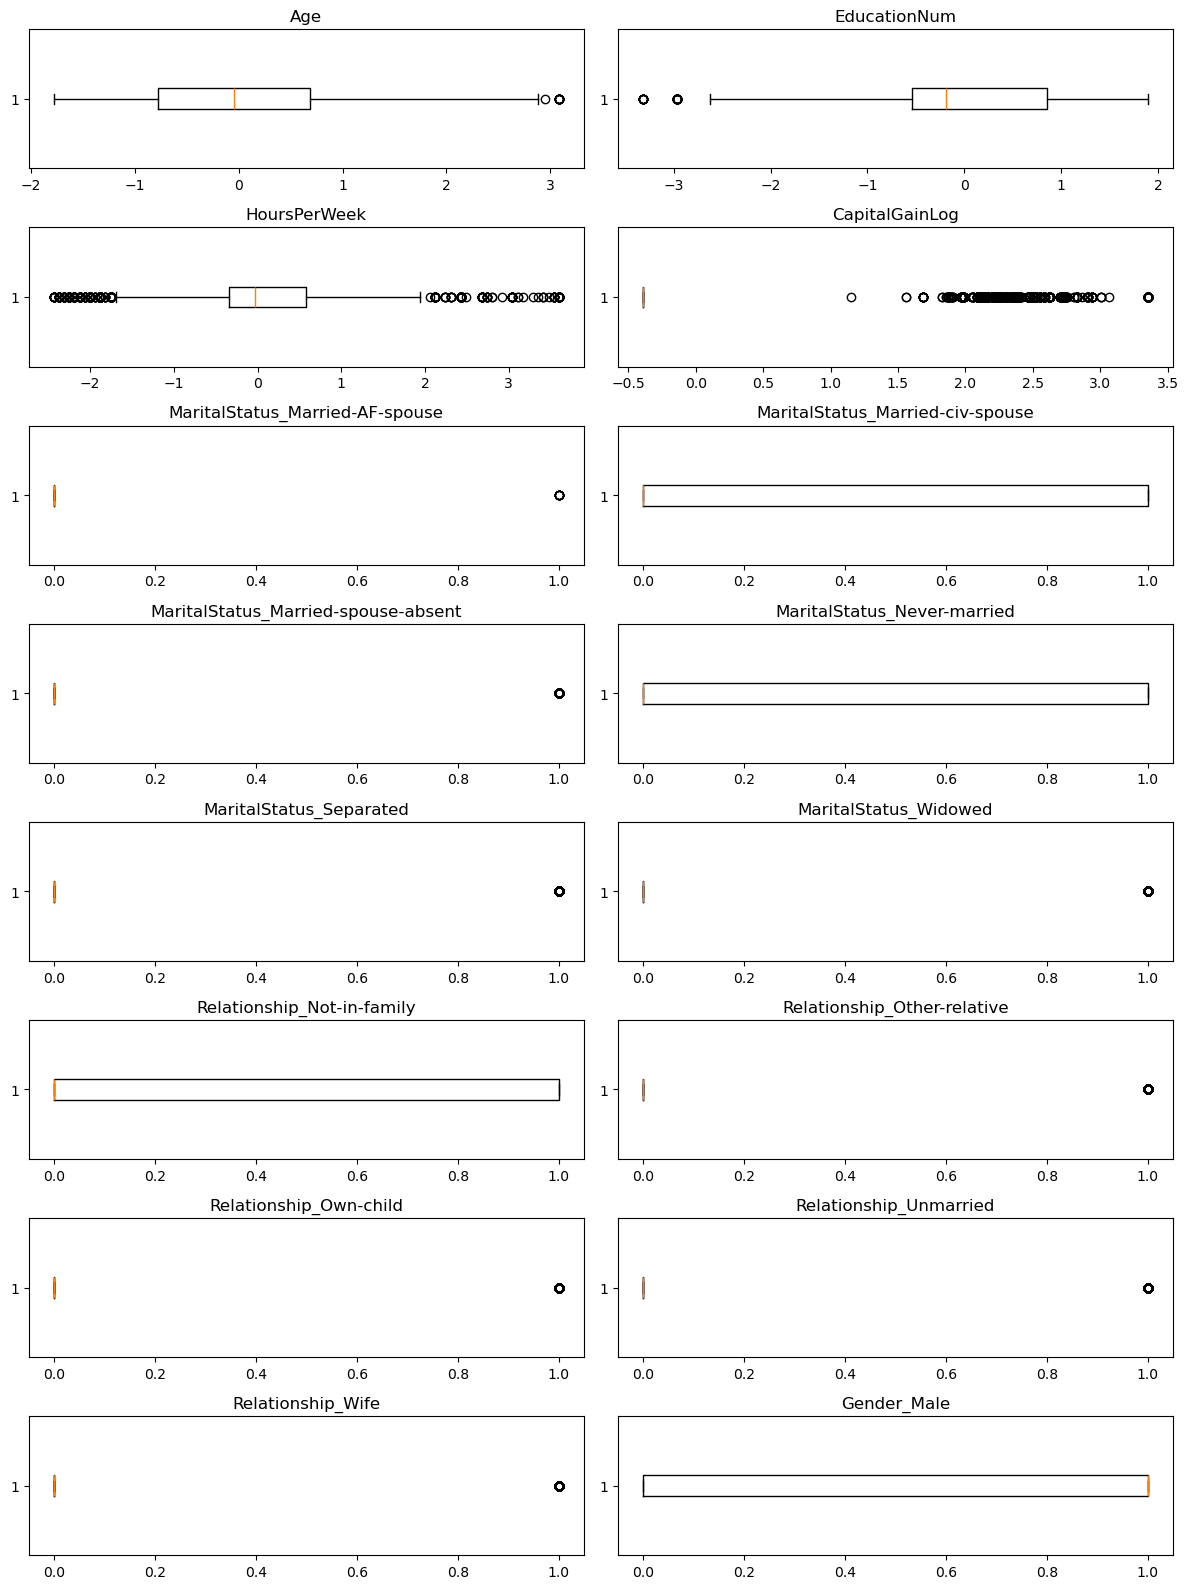

In [ ]:
import math

num_cols = data_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()
n = len(num_cols)
cols = 2  # número de columnas en la figura
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, rows*2))
axes = axes.flatten()

for ax, col in zip(axes, num_cols):
    ax.boxplot(data_processed[col].dropna(), vert=False)
    ax.set_title(col)

# Ocultar ejes sobrantes
for i in range(len(num_cols), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()



<font color="red">vale aqui ha cambiado no se porque, debe ser algo de numerical data</font>

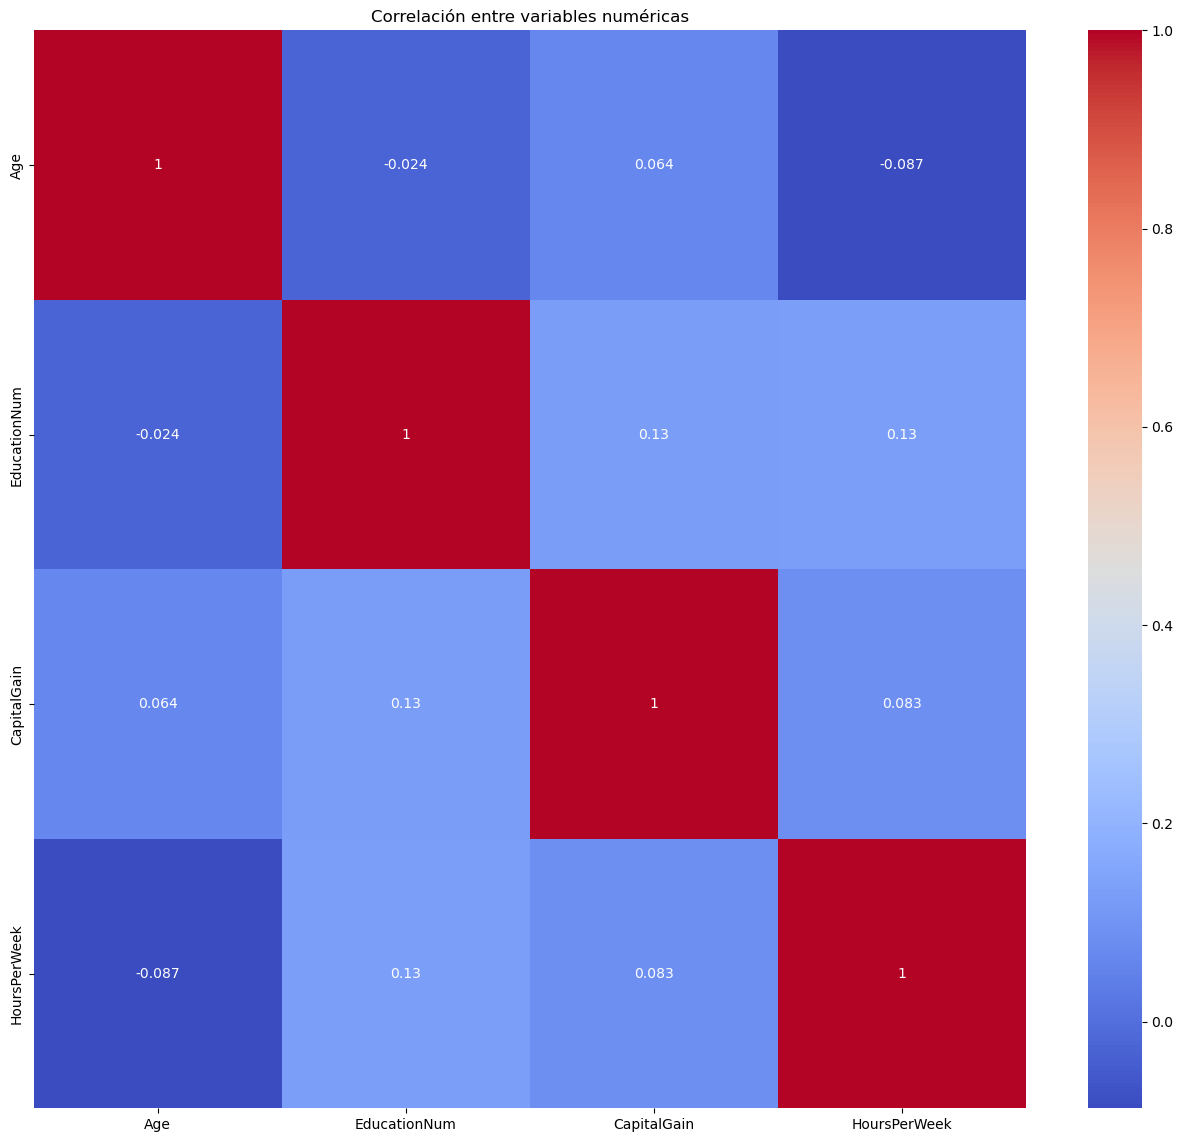

In [28]:
plt.figure(figsize=(16,14))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlación entre variables numéricas")
plt.show()

### 2. Hierarchical Clustering

<font color="red">esto moverlo al siguiente punto </font>

Primeramente, declaramos la semilla para que el proceso de clustering sea reproducible.

In [35]:
random_state = 42

Para clustering, necesitamos solo variables numéricas o variables codificadas numéricamente, y gracias a los métodos aplicados durante la limpieza podemos trabajar con todas las varibles de nuestro dataset.

2.1 Elección de Linkage

Comenzamos haciendo un clustering jerárquico, por tanto no tenemos que saber de primeras el número de clusterings K que queremos. No obstante debemos decidir que tipo de linkage nos dará los mejores resultados, para esto probaremos estos y evaluaremos los efectos de cada uno tanto gráficamente (dendogramas) como con medidas de evaluación.

Se aplicaron cuatro métodos de linkage: single, complete, average y Ward.

In [33]:
data_cluster = data_processed.values.astype(float)
print(data_cluster)

[[-0.31538968  0.8520182  -0.0327975  ...  0.          0.
   1.        ]
 [ 0.41792416  0.8520182  -1.69479046 ...  0.          0.
   1.        ]
 [ 0.55125395 -0.53764505  0.27497898 ...  0.          0.
   1.        ]
 ...
 [ 1.41789758  1.54684982  1.1983084  ...  0.          0.
   1.        ]
 [-0.0487301  -0.19022924 -0.0327975  ...  0.          0.
   0.        ]
 [ 0.55125395 -0.53764505 -0.0327975  ...  0.          1.
   0.        ]]


Comenzamos creando los distintos dendogramas para los 4 distintos tipos de linkage.

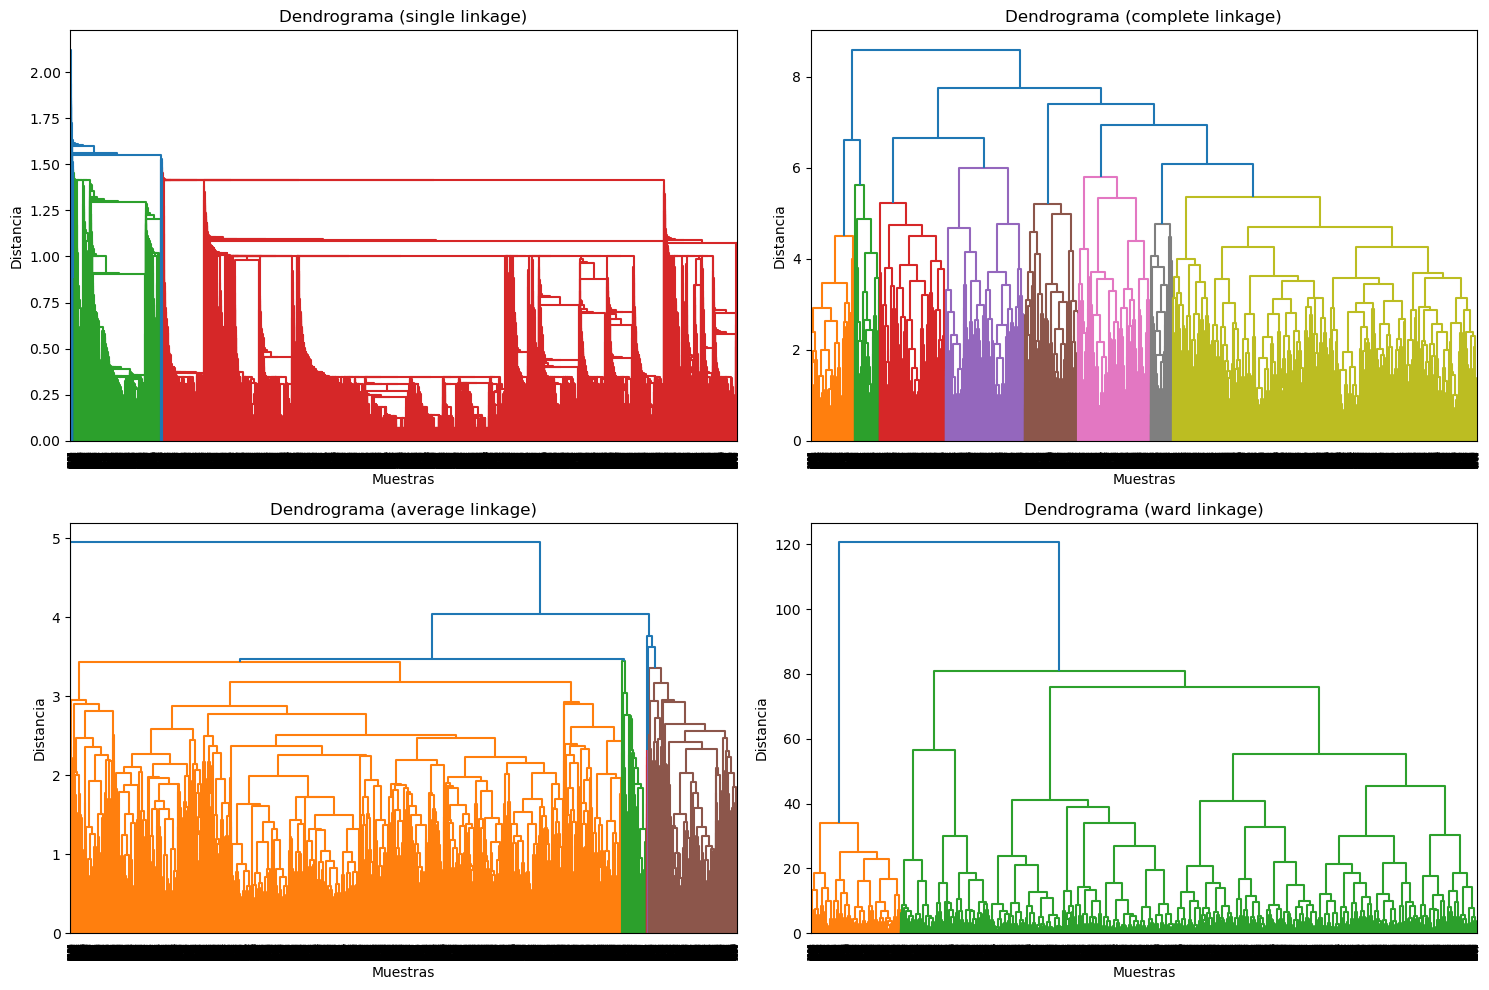

In [34]:
linkage_methods = ['single', 'complete', 'average', 'ward']
plt.figure(figsize=(15, 10))

for i, method in enumerate(linkage_methods, 1):
    plt.subplot(2, 2, i)
    linkage_matrix = linkage(data_cluster, method=method)  # data_cluster = dataset numérico listo
    dendrogram(linkage_matrix)
    plt.title(f"Dendrograma ({method} linkage)")
    plt.xlabel("Muestras")
    plt.ylabel("Distancia")

plt.tight_layout()
plt.show()

Una vez obtenidos los cuatro dendogramas, podemos empezar a interpretarlos y compararlos con ánimo de escoger un tipo de linkage que mejor se adapte a nuestro data set. 

Observaciones: 

*Single Linkage:* en el primer caso, usando single linkage, vemos que las instancias han resultado en grupos que se forman sin saltos grandes ya que el rango de distancia lega solo hasta 2. Esto se debe a que con single linkage las fusiones ocurren muy pronto, pues se estan teniendo en cuenta las distancias mínimas, por ello vemos largas cadenas en el dendograma. Nos está mostrando un árbol poco estable. Definitivamente, single linkage no resulta útil para hayar clusters reales.

*Complete Linkage:* en este vemos una gran mejora respecto al anterior, se ve un árbol mucho más estable, donde los grupos se van formando con salto más marcados y se ven clusters claramente.

*Average Linkage:* ese parece ser un intermedio entre single y complete, lo cual tiene sentido respecto a su definición, ya que se basa en medias, por tanto si se ve una jerarquía más clara que para single, pero más alargada y con saltos menos distantes que con complete linkage. En este caso el average linkage no parece ser adecuado.

*Ward Linkage:* Finalmente, ward muestra un dendograma que a nivel visual se ve muy estructurado y equilibrado visualmente, los saltos son más grandes que para los demás tipos pero son pocos, realizandose agrupaciones de manera proporcional, las alturas de fusion crecen muy suavemente. Para nuestros datos escalados (estandarizados) es el más coherente. Vemos también que se llegan a distancias de hasta 120, mostrando que se forman fusiones bastante más costosas.

**Para elegir el valor de k vamos a fijarnos en el dendrograma de Ward, ya que nos da un valor más estable. Observando determinamos que el valor de k será entre 3 y 4.**

Podemos ver en el dendograma de Ward que que, llegando a distancias de entre 60-100, se pueden ver 3 y 4 clusters, el salto entre el que se une para eliminar un cluster, es muy corto relativamente, dando a entender que son muy similares entre sí por lo que, tomar 3 clusters podría ser justificado como una simplificación que no implica un gran error adicional.

También se puede probar otra métrica, como la distancia Manhattan (L1), para explorar cómo cambia la estructura de los clusters. Esto es útil porque:

 - Manhattan mide la distancia sumando diferencias absolutas entre coordenadas, mientras que Euclídea usa la raíz cuadrada de la suma de cuadrados.

- Algunas distribuciones de datos o variables con escalas heterogéneas pueden producir agrupamientos más estables o menos sensibles a outliers con Manhattan.


El problema es que con esta medida de distancia no podemos aplicar el linkage ward, por lo que, si no logramos una mejor jerarquía que la obtenida con este anteriormente, nos quedaremos con el ward linkage.

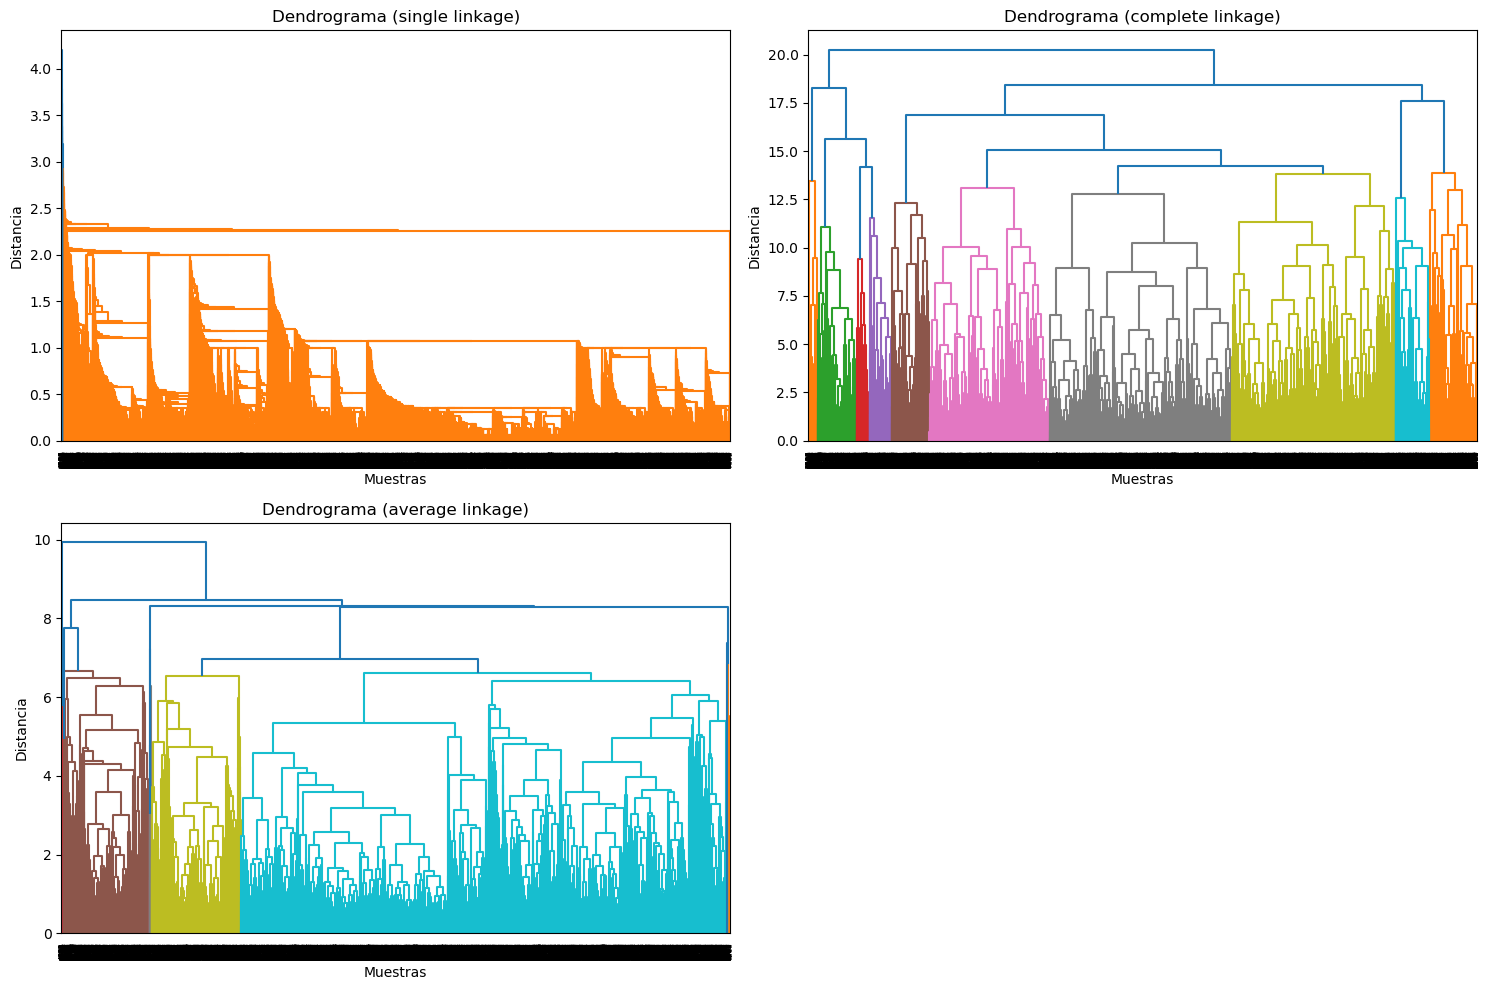

In [37]:
linkage_methods = ['single', 'complete', 'average']
data_cluster = data_processed.values
plt.figure(figsize=(15, 10))

for i, method in enumerate(linkage_methods, 1):
    plt.subplot(2, 2, i)
    linkage_matrix = linkage(data_cluster, method=method, metric='cityblock') # data_cluster = dataset numérico listo
    dendrogram(linkage_matrix)
    plt.title(f"Dendrograma ({method} linkage)")
    plt.xlabel("Muestras")
    plt.ylabel("Distancia")

plt.tight_layout()
plt.show()

<font color="red">revisar si este parrafo se ajusta a los nuevos dendogramas </font>

Al usar la distancia Manhattan, el dendrograma tiende a agrupar todas las muestras en un solo cluster, mostrando poca diferenciación entre grupos. Esto ocurre porque, tras la normalización con StandardScaler, las diferencias absolutas entre variables son pequeñas, y Manhattan no distingue claramente los clusters. Por el contrario, la distancia euclídea es más adecuada en este caso, ya que refleja mejor la similitud real entre las observaciones en el espacio normalizado, permitiendo identificar agrupamientos más claros y significativos.

2.2 Clustering Final

En conclusión, decidimos que el mejor método de linkage es ward, por supuesto entonces con la distancia euclídea. En cuanto al clustering que más razonable es, podemos ver como fue mencionado anteriormente, que el dendograma nos muestra un gran salto en 4 clusterings, aunque tomar 3 también parece adecuado ya que dos de estos cuatro se juntan con un salto muy corto. Para cuantificar nuestro análisis usamos el coeficiente de silhoutte, a pesar de que sospechemos de 3 o 4, tomaremos un rango más amplio para tener una mejor visión.

k=2 → Silhouette: 0.316
k=3 → Silhouette: 0.233
k=4 → Silhouette: 0.165
k=5 → Silhouette: 0.166
k=6 → Silhouette: 0.158
k=7 → Silhouette: 0.155
k=8 → Silhouette: 0.140
k=9 → Silhouette: 0.151


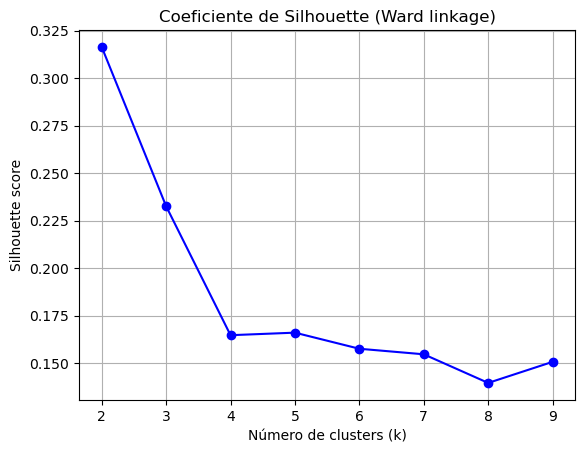

In [ ]:
# Evaluamos Silhouette para distintos k
range_k = range(2, 8)
scores = []

for k in range_k:
    model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = model.fit_predict(data_processed)
    sil = silhouette_score(data_processed, labels)
    scores.append(sil)
    print(f"k={k} → Silhouette: {sil:.3f}")

# Representamos los resultados
plt.plot(range_k, scores, "bo-")
plt.title("Coeficiente de Silhouette (Ward linkage)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

Con el coeficiente silhoutte se muestra que el verdadero pico esta en 2 clusters, aunque por lo general los resultados de este coeficiente son muy bajos, lo que nos lleva a que hay una estructura débil en los datos, posiblemente como resultado de la cantidad de variables dummy resultante de las que en principio eran categóricas. Por interpretabilidad del dendograma, y por que para k = 3 el valor del coeficiente sigue siendo relativamente mayor al resto, tomaremos este número de clusters como el más adecuado.

Queremos ver como son estos clusters, a nivel semántico, es decir, que tipo de individuos agrupan y si esto tiene sentido y es interpretable, podiendo entender además si realmente hay una jerarquía de clusters significativa.

Primera encontramos el clustering jerarquico definitivo.

In [51]:
model = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels = model.fit_predict(data_processed)
data['cluster'] = labels

Ahora visualizamos dicho modelo. Podemos ver por una parte como se han repartido los valores numéricos, mediante la media, y por otra los categóricos mediante porcentaje.

In [53]:
summary = data.groupby('cluster')[['Age', 'EducationNum', 'HoursPerWeek', 'CapitalGainLog']].mean().round(2)
display(summary)

Age  EducationNum  HoursPerWeek  CapitalGainLog
cluster                                                   
0        40.37         11.02         42.30            0.00
1        48.17         11.42         43.34            8.91
2        57.68          7.05         28.01            0.00

In [55]:
cat_cols = ['MaritalStatus', 'Relationship', 'Gender']

cat_summary = (
    data.groupby('cluster')[cat_cols]
        .agg(lambda x: x.value_counts().index[0])
)

for col in cat_cols:
    print(f"\nDistribución de {col} por cluster:")
    display(pd.crosstab(data['cluster'], data[col], normalize='index').round(2))

display(cat_summary)


Distribución de MaritalStatus por cluster:


MaritalStatus  Divorced  Married-AF-spouse  Married-civ-spouse  \
cluster                                                          
0                  0.18                0.0                0.41   
1                  0.11                0.0                0.69   
2                  0.10                0.0                0.58   

MaritalStatus  Married-spouse-absent  Never-married  Separated  Widowed  
cluster                                                                  
0                               0.02           0.31       0.04     0.04  
1                               0.01           0.13       0.01     0.03  
2                               0.01           0.09       0.04     0.18


Distribución de Relationship por cluster:


Relationship  Husband  Not-in-family  Other-relative  Own-child  Unmarried  \
cluster                                                                      
0                0.33           0.29            0.03       0.14       0.13   
1                0.61           0.19            0.02       0.03       0.07   
2                0.53           0.28            0.03       0.02       0.09   

Relationship  Wife  
cluster             
0             0.08  
1             0.08  
2             0.05


Distribución de Gender por cluster:


Gender   Female  Male
cluster              
0          0.38  0.62
1          0.24  0.76
2          0.32  0.68

MaritalStatus Relationship Gender
cluster                                        
0        Married-civ-spouse      Husband   Male
1        Married-civ-spouse      Husband   Male
2        Married-civ-spouse      Husband   Male

Vemos de los resultados que el clustering jerárquico ha demostrado muy mal agrupamiento, para los 3 clusters parece que ha diferenciado a los individuos únicamente basándose principalmente en las características de EducationNum, HoursPerWeek y CapitalGain. 

El segundo cluster parece contener a aquellos individuos que sí tienen ganancias, lo cual es de esperar ya que sabemos que esta variable esta llena de 0s y por tanto hay una gran diferencia entre estos individuos, el primer cluster tiene a individuos que tienen alta eduación y trabajan un número alto de horas a la semana, sin embargo no tienen ganancias. Por último el tercer cluster muestra individuos que tienen menos años de educación y trabajan menos horas a la semana, además tienden a ser individuos más mayores.

A nivel de características categóricas, estas parecen tener poco peso a la hora de hacer los clusters, ya que parecen haberse distribuido bastante equitativamente entre estos, por tanto a nivel de las categorías más frecuentes en cada cluster, no hay diferencia, y se muestran las categorías más frecuentes a nivel del data set original completo (predominan los hombres, y por tanto los maridos, y el estado matrimonial de casados civilmente).

Queremos saber si la jerarquía establecida por el ward linkage es significativa, es decir, si se agrupan las instancias arbitrariamente o realmente los individuos se van pareciendo cada vez más a medida que bajamos por ella (por ejemplo, primero se juntan por genero y relación, luego por edad, luego por educación etc.)

Esto no se puede ver claramente a partir del dendograma, pero podemos ver para diferentes k como son los clusterings y si se ve que hay significado a estos de manera jerárquica.

In [66]:
range_k = range(2, 8)
scores = []

for k in range_k:
    model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = model.fit_predict(data_processed)
    data['cluster'] = labels

    print("valores numéricos")
    summary = data.groupby('cluster')[['Age', 'EducationNum', 'HoursPerWeek', 'CapitalGainLog']].mean().round(2)
    display(summary)

    print("valores categóricos")
    cat_summary = (
        data.groupby('cluster')[cat_cols]
        .agg(lambda x: x.value_counts().index[0])
    )

    display(cat_summary)

valores numéricos


Age  EducationNum  HoursPerWeek  CapitalGainLog
cluster                                                   
0        43.04         10.41         40.09            0.00
1        48.17         11.42         43.34            8.91

valores categóricos


MaritalStatus Relationship Gender
cluster                                        
0        Married-civ-spouse      Husband   Male
1        Married-civ-spouse      Husband   Male

valores numéricos


Age  EducationNum  HoursPerWeek  CapitalGainLog
cluster                                                   
0        40.37         11.02         42.30            0.00
1        48.17         11.42         43.34            8.91
2        57.68          7.05         28.01            0.00

valores categóricos


MaritalStatus Relationship Gender
cluster                                        
0        Married-civ-spouse      Husband   Male
1        Married-civ-spouse      Husband   Male
2        Married-civ-spouse      Husband   Male

valores numéricos


Age  EducationNum  HoursPerWeek  CapitalGainLog
cluster                                                   
0        57.68          7.05         28.01            0.00
1        45.40         11.53         49.56            0.00
2        37.29         10.71         37.86            0.00
3        48.17         11.42         43.34            8.91

valores categóricos


MaritalStatus   Relationship  Gender
cluster                                           
0        Married-civ-spouse        Husband    Male
1        Married-civ-spouse        Husband    Male
2             Never-married  Not-in-family  Female
3        Married-civ-spouse        Husband    Male

valores numéricos


Age  EducationNum  HoursPerWeek  CapitalGainLog
cluster                                                   
0        37.29         10.71         37.86            0.00
1        45.40         11.53         49.56            0.00
2        51.22          4.79         36.77            0.00
3        48.17         11.42         43.34            8.91
4        67.57         10.52         14.58            0.00

valores categóricos


MaritalStatus   Relationship  Gender
cluster                                           
0             Never-married  Not-in-family  Female
1        Married-civ-spouse        Husband    Male
2        Married-civ-spouse        Husband    Male
3        Married-civ-spouse        Husband    Male
4        Married-civ-spouse        Husband    Male

valores numéricos


Age  EducationNum  HoursPerWeek  CapitalGainLog
cluster                                                   
0        31.08          9.90         33.74            0.00
1        45.40         11.53         49.56            0.00
2        44.27         11.62         42.46            0.00
3        48.17         11.42         43.34            8.91
4        67.57         10.52         14.58            0.00
5        51.22          4.79         36.77            0.00

valores categóricos


MaritalStatus   Relationship  Gender
cluster                                           
0             Never-married      Own-child    Male
1        Married-civ-spouse        Husband    Male
2                  Divorced  Not-in-family  Female
3        Married-civ-spouse        Husband    Male
4        Married-civ-spouse        Husband    Male
5        Married-civ-spouse        Husband    Male

valores numéricos


Age  EducationNum  HoursPerWeek  CapitalGainLog
cluster                                                   
0        45.40         11.53         49.56            0.00
1        48.17         11.42         43.34            8.91
2        44.27         11.62         42.46            0.00
3        31.19         10.20         17.77            0.00
4        67.57         10.52         14.58            0.00
5        51.22          4.79         36.77            0.00
6        31.01          9.72         43.02            0.00

valores categóricos


MaritalStatus   Relationship  Gender
cluster                                           
0        Married-civ-spouse        Husband    Male
1        Married-civ-spouse        Husband    Male
2                  Divorced  Not-in-family  Female
3             Never-married      Own-child  Female
4        Married-civ-spouse        Husband    Male
5        Married-civ-spouse        Husband    Male
6             Never-married      Own-child    Male

Parece ser que CapitalGain es la característica más determinística, el modelo agrupa a los que tienen ganancia en un cluster desde el principio creando una agrupación muy fuerte. El resto podemos ver que, en principio (k = 7) se diferencian en muchas cosas, por ejemplo, mujeres mayores y jovenes y a su vez que trabajen muchas o pocas horas, hombres de baja educacion y alta, no casados y casado, etc. Y poco a poco se van unificando, por ejemplo llega un punto en el que los clusters dejan de diferenciar tanto por género y diferencian fijándose más en la educación, horas de trabajo etc.

Entonces, podemos concluir que si hay un clustering jerárquico significativo, las fusiones no son arbitrarias, no obstante, hay ciertas características que parecen dominarlo. De hecho, tras este análisis más a fondo de los clusters resultantes, parece que haber elegido k = 4 como número de clusterings podría haber sido más adecuado, pues hay un cluster consistente de mujeres no casadas, jovenes, y de mucha educación que se pierde al eliminar este clustering, posiblemente por que se fusione con hombres cuyos valores numéricos se aproximen mucho a los de estas (estos tienen más peso que los categóricos).

### 3. Partitional Clustering

In [56]:
# To plot pretty figures
#%matplotlib inline
import matplotlib as mpl
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

In [57]:
def plot_silhouette(model, X):
    mu = model.cluster_centers_
    K, D = mu.shape
    y_pred = model.labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)
    silhouette_scores = silhouette_score(X, model.labels_)
    cmap = plt.get_cmap("Pastel2")
    colors = [cmap(i) for i in range(K)]
    padding = len(X) // 30
    pos = padding
    for i in range(K):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        color = mpl.cm.Spectral(i / K)
        # color = colors[i]
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs, facecolor=color, edgecolor=color, alpha=0.7)
        pos += len(coeffs) + padding
    score = silhouette_scores
    plt.axvline(x=score, color="red", linestyle="--")
    plt.title("$k={}, score={:0.2f}$".format(K, score), fontsize=16)

def plot_centroids(centroids, weights=None, circle_color="w", cross_color="k"):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(
        centroids[:, 0], centroids[:, 1], marker="o", s=30, linewidths=8, color=circle_color, zorder=10, alpha=0.9
    )
    plt.scatter(
        centroids[:, 0], centroids[:, 1], marker="x", s=50, linewidths=50, color=cross_color, zorder=11, alpha=1
    )

def plot_decision_boundaries(model, X, resolution=1000):
    mu = model.cluster_centers_
    K, D = mu.shape
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), np.linspace(mins[1], maxs[1], resolution))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # cmap = [mpl.cm.Spectral( (i / K)) for i in range(K)]
    cmap = "Pastel2"
    # cmap = mpl.cm.Spectral(K)
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap=cmap)
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors="k")
    plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)
    plot_centroids(model.cluster_centers_)
    plt.title(f"K={K}")


In [58]:
X = data_processed.values

Try K-means with different values of K

Para este paso se fija la semilla del generador de números aleatorios para garantizar reproducibilidad. KMeans comienza con centroides iniciales aleatorios, y fijar la semilla permite obtener siempre el mismo resultado al ejecutar el código varias veces.

Por KMeans realizará 10 inicializaciones distintas con centroides aleatorios y elegirá la que genere la menor inercia. Esto reduce el riesgo de que el algoritmo quede atrapado en un mínimo local y mejora la estabilidad del clustering.

In [59]:
Ks = range(1, 10)
kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X) for k in Ks]

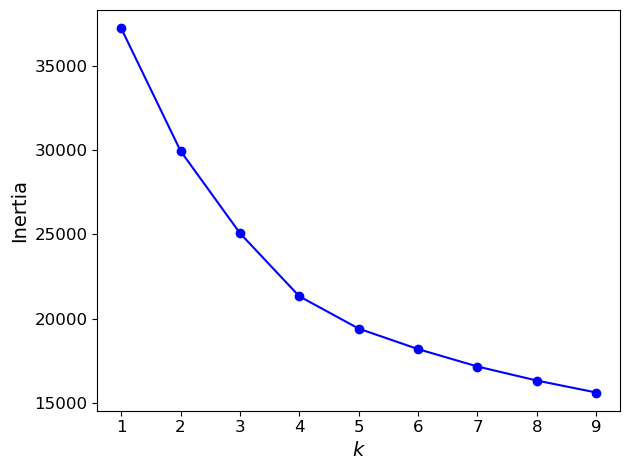

In [61]:
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure()
plt.plot(Ks, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
# plt.axis([1, 8.5, 0, 1300])
plt.tight_layout()
plt.show()

Esta grafica nos permite observar el codo, en este caso se encuentren  k= ya que de k= en adelante la pendiente se aplana.

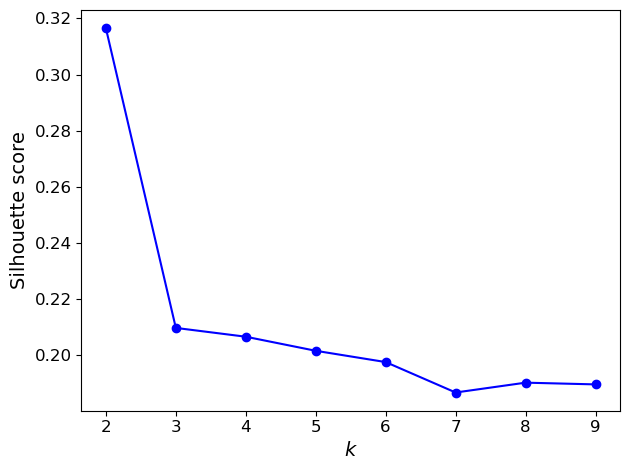

In [62]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

plt.figure()
plt.plot(Ks[1:], silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
# plt.axis([1.8, 8.5, 0.55, 0.7])
plt.tight_layout()
plt.show()

El Silhouette aumenta mucho de k= a k=, alcanzando su máximo valor ≈  en k=.

Luego disminuye para k= y k=, lo que indica que los clusters empiezan a solaparse más.
El número de clusters óptimo según el método del Silhouette es k = .

k=2, silhouette score=0.32
k=3, silhouette score=0.21
k=4, silhouette score=0.21
k=5, silhouette score=0.20
k=6, silhouette score=0.20
k=7, silhouette score=0.19
k=8, silhouette score=0.19


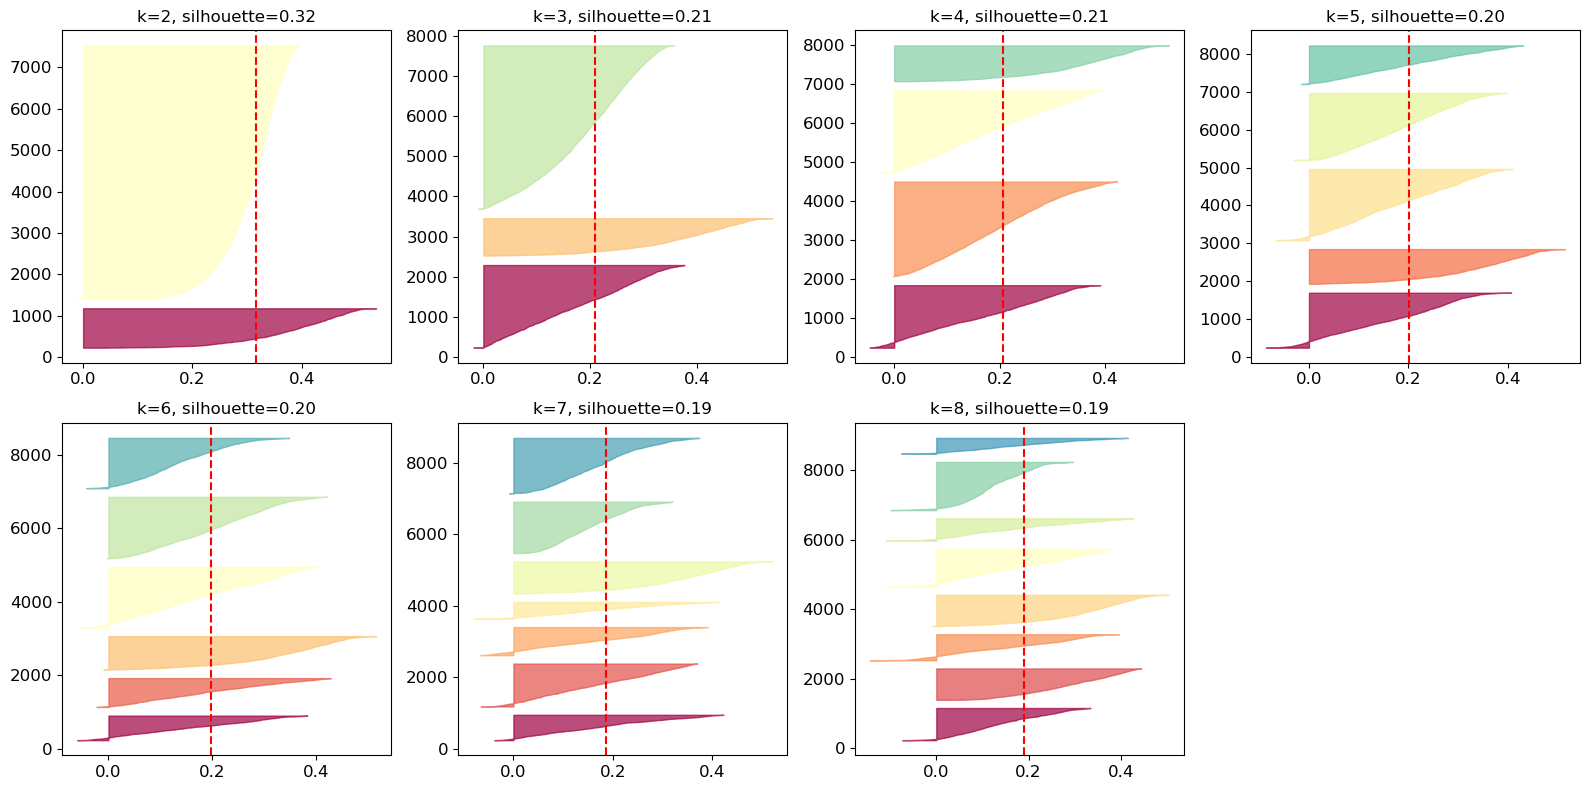

In [63]:
ks = [2, 3, 4, 5, 6, 7, 8]

n_cols = 4  # columnas por fila
n_rows = int(np.ceil(len(ks) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()  # para indexar fácilmente

for i, k in enumerate(ks):
    model = kmeans_per_k[k-1]  # recuerda ajustar índice de la lista
    X_labels = model.labels_
    score = silhouette_score(X, X_labels)
    print(f"k={k}, silhouette score={score:.2f}")
    
    plt.sca(axes[i])
    plot_silhouette(model, X)
    axes[i].set_title(f"k={k}, silhouette={score:.2f}")

# Ocultar subplots sobrantes si los hay
for j in range(len(ks), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Plot the clustering for all K

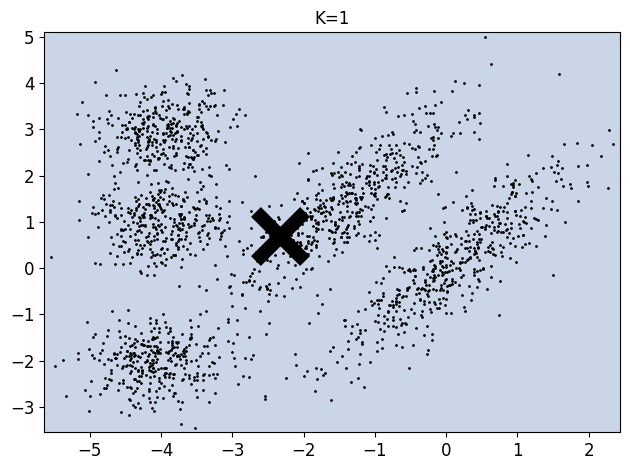

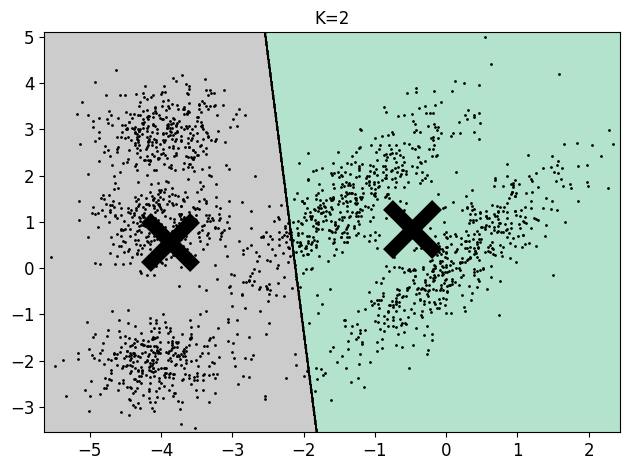

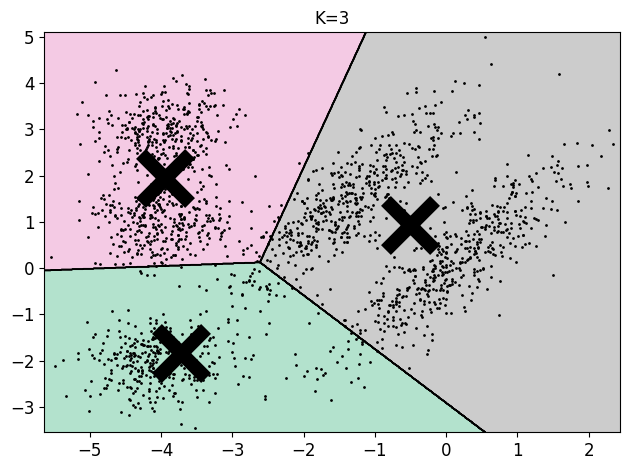

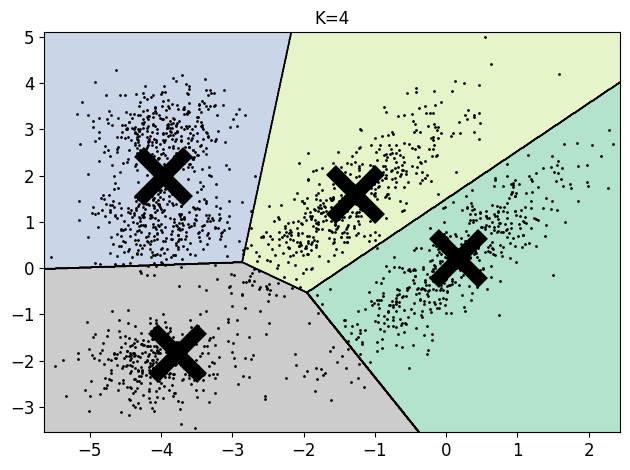

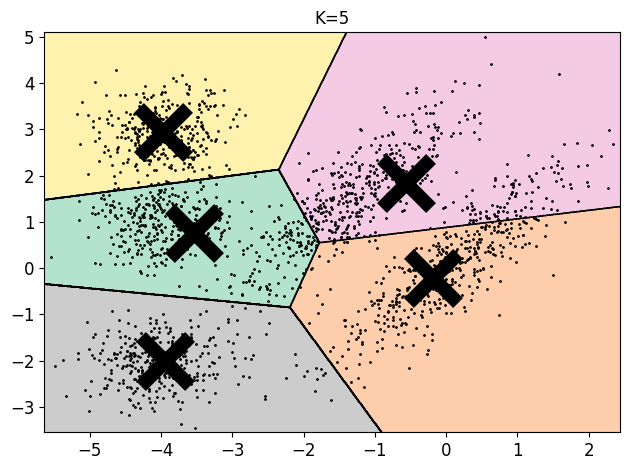

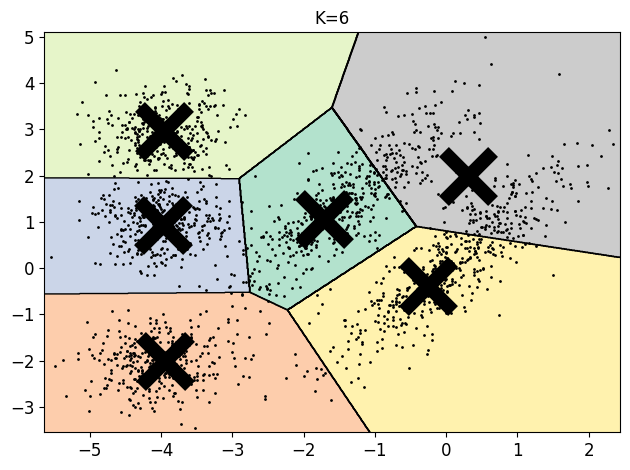

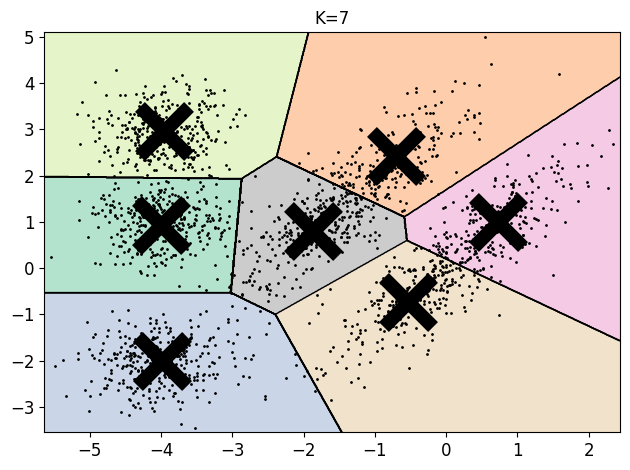

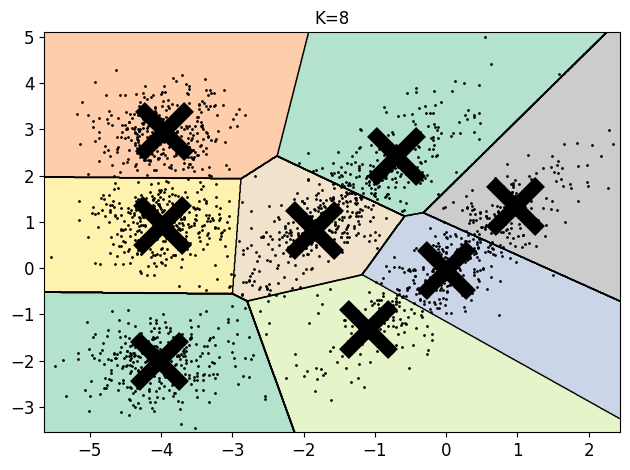

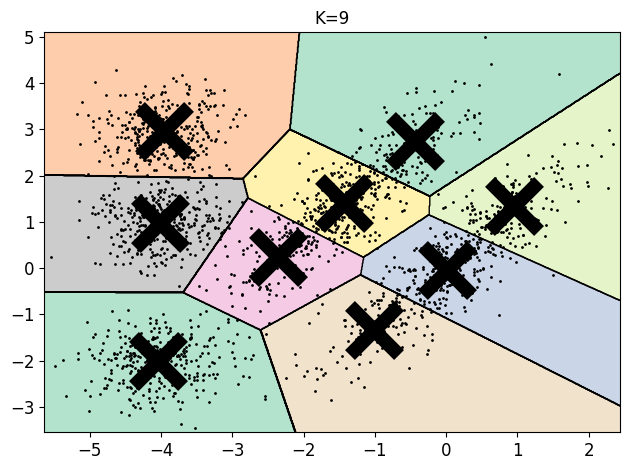

In [ ]:
for model in kmeans_per_k:
    K, D = model.cluster_centers_.shape
    plt.figure()
    plot_decision_boundaries(model, X)
    fname = f"kmeans_silhouette_dboundaries{K}.pdf"
    plt.tight_layout()

El clustering con X grupos proporciona una separación clara y consistente entre los clusters, tanto numéricamente (silhouette score) como visualmente (gráficos de silueta y fronteras de decisión), siendo por tanto la elección más adecuada para este conjunto de datos.

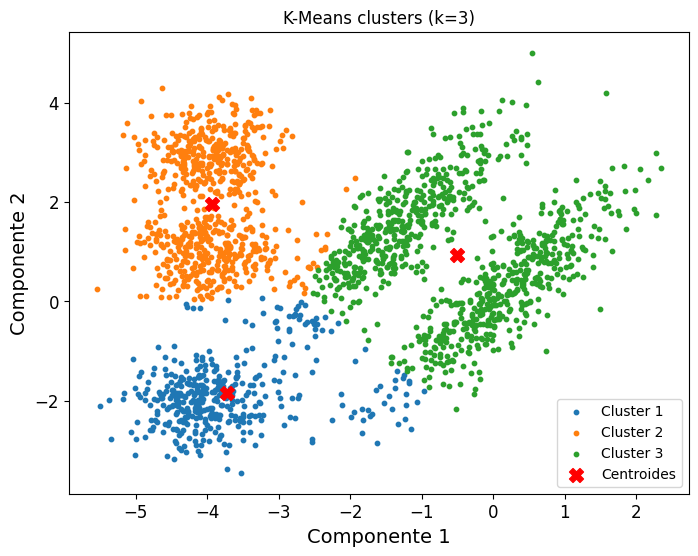

In [ ]:
k = 6  
model = kmeans_per_k[k-1]
labels = model.labels_
centroids = model.cluster_centers_

plt.figure(figsize=(8,6))
for i in range(k):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], s=10, label=f'Cluster {i+1}')
plt.scatter(centroids[:,0], centroids[:,1], c='red', marker='X', s=100, label='Centroides')
plt.title(f'K-Means clusters (k={k})')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend()
plt.show()


Ahora para ver los datos y como se ehhan agrupado podemos crear una nueva columna que nos diga a que cluster pertenece y podemos desescalara los datos paar analizar visualemente como son las agrupaciones de los datos.

In [ ]:
data_clustered = data.copy()  # ya limpio, sin duplicados ni NaN
data_cluster = data_clustered.values.astype(float)  # convertir a numpy

# K-Means sobre todo el dataset
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(data_cluster)

# Añadir columna Cluster
data_clustered['Cluster'] = labels

# Ver algunas filas de un cluster
print(data_clustered[data_clustered['Cluster'] == 0].head())

# Contar cuántos datos hay en cada cluster
print(data_clustered['Cluster'].value_counts())



        Age  EducationNum  HoursPerWeek  Gender_ Male  \
1  0.417924      0.852018     -1.694790      0.743598   
2  0.551254     -0.537645      0.274979      0.743598   
3 -0.915374      0.852018     -0.032797      0.743598   
6 -0.582049     -1.927308     -0.032797      0.743598   
7  0.817914      0.852018     -0.032797      0.743598   

   MaritalStatus_ Married-AF-spouse  MaritalStatus_ Married-civ-spouse  \
1                         -0.033693                           1.057347   
2                         -0.033693                           1.057347   
3                         -0.033693                           1.057347   
6                         -0.033693                           1.057347   
7                         -0.033693                           1.057347   

   MaritalStatus_ Married-spouse-absent  MaritalStatus_ Never-married  \
1                             -0.129295                     -0.586134   
2                             -0.129295                     -0.586

In [ ]:
data_clustered = data_cleaned.copy()
data_clustered['Cluster'] = labels

data_original = pd.DataFrame(scaler.inverse_transform(data), columns=data_cleaned.columns)
data_original['Cluster'] = labels



In [ ]:
print(data_original.head())


    Age  EducationNum  HoursPerWeek  Gender_ Male  \
0  39.0          13.0          40.0           1.0   
1  50.0          13.0          13.0           1.0   
2  52.0           9.0          45.0           1.0   
3  30.0          13.0          40.0           1.0   
4  25.0           9.0          35.0           1.0   

   MaritalStatus_ Married-AF-spouse  MaritalStatus_ Married-civ-spouse  \
0                               0.0                                0.0   
1                               0.0                                1.0   
2                               0.0                                1.0   
3                               0.0                                1.0   
4                               0.0                                0.0   

   MaritalStatus_ Married-spouse-absent  MaritalStatus_ Never-married  \
0                                   0.0                           1.0   
1                                   0.0                           0.0   
2                

Ahora vamos a leer como se agruparon, imrimiendo los tres grupos diferentes.

In [ ]:
# Suponiendo que k = número de clusters
k = data_original['Cluster'].nunique()

for i in range(k):
    print(f"\n--- Cluster {i} ---\n")
    print(data_original[data_original['Cluster'] == i].head())



--- Cluster 0 ---

    Age  EducationNum  HoursPerWeek  Gender_ Male  \
1  50.0          13.0          13.0           1.0   
2  52.0           9.0          45.0           1.0   
3  30.0          13.0          40.0           1.0   
6  35.0           5.0          40.0           1.0   
7  56.0          13.0          40.0           1.0   

   MaritalStatus_ Married-AF-spouse  MaritalStatus_ Married-civ-spouse  \
1                               0.0                                1.0   
2                               0.0                                1.0   
3                               0.0                                1.0   
6                               0.0                                1.0   
7                               0.0                                1.0   

   MaritalStatus_ Married-spouse-absent  MaritalStatus_ Never-married  \
1                                   0.0                           0.0   
2                                   0.0                           0.0 

## 4. DBSCAN

Lo primero que realizaremos será una proyección 2D para hacer una primera visualización de nuestros datos.

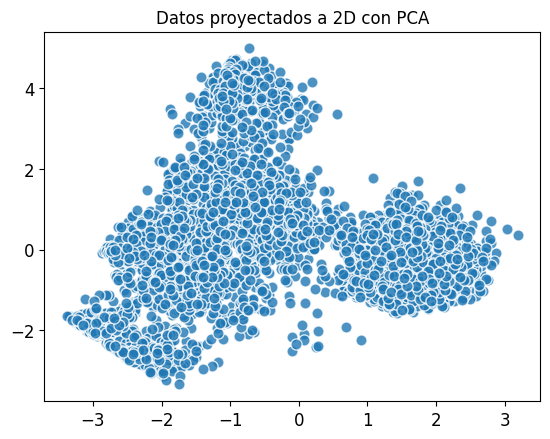

In [ ]:
X_scaled = data[num_cols].values

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.8, s=64, edgecolors='white')
plt.title("Datos proyectados a 2D con PCA")
plt.show()


Observamos que de forma general, los puntos forman una especie de nube central con ciertas zonas más densas, lo que indica que probablemente haya subgrupos dentro del conjunto de datos, aunque no están completamente separados.

Además, se ven algunos puntos aislados alrededor de la nube principal; DBSCAN podría etiquetarlos como ruido (-1) según el valor de eps.

*Como la nube tiene formas irregulares; esto es un caso donde DBSCAN suele funcionar mejor que KMeans, porque KMeans asume clusters más esféricos.*

eps=0.3 → clusters: 163, puntos de ruido: 3935


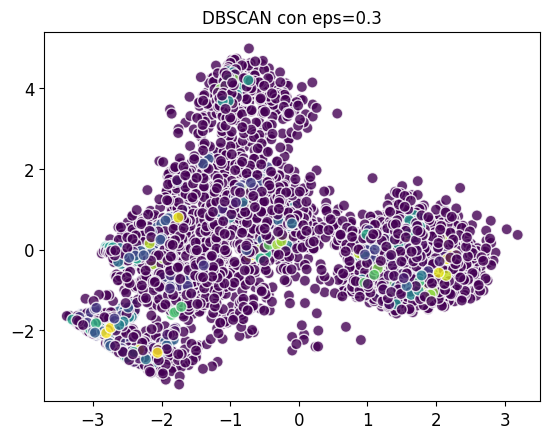

eps=0.5 → clusters: 55, puntos de ruido: 1631


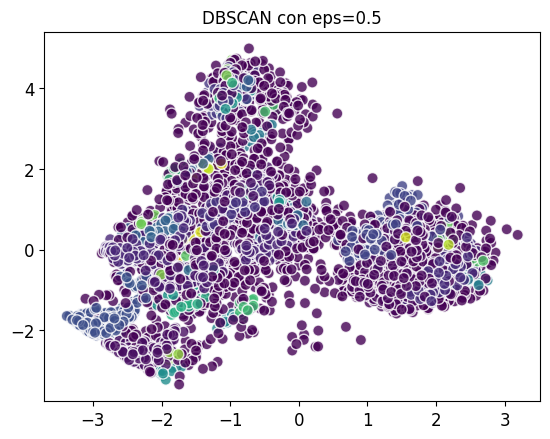

eps=0.7 → clusters: 48, puntos de ruido: 1001


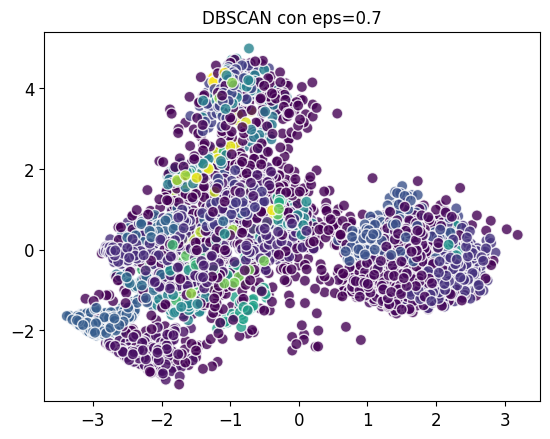

In [ ]:
eps_values = [0.3, 0.5, 0.7]  # Ajustar según tus datos
min_samples = 5

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)
    
    print(f"eps={eps} → clusters: {n_clusters}, puntos de ruido: {n_noise}")
    
    # Graficar en 2D
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=64, alpha=0.8, edgecolors='white')
    plt.title(f"DBSCAN con eps={eps}")
    plt.show()


Para ajustar mejor los valores vamos a visulizar la grafica de la distancia al 5º vecino más cercano, se eligió analizar la distancia al 5º vecino porque el parámetro min_samples se estableció en 5. 

Esta gráfica permite identificar el valor de eps adecuado para DBSCAN, mostrando la distancia a partir de la cual los puntos empiezan a considerarse aislados y, por tanto, ruido. El “codo” de la curva indica un rango de densidad óptimo para formar clusters, facilitando la selección de un eps que agrupe correctamente los puntos densos del dataset.

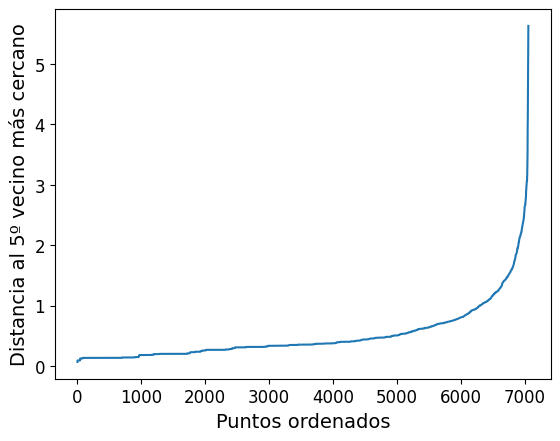

In [ ]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, _ = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, 4])  # 4 porque n_neighbors=5
plt.plot(distances)
plt.ylabel("Distancia al 5º vecino más cercano")
plt.xlabel("Puntos ordenados")
plt.show()


Basándonos en que el “codo” de la gráfica  está entre 8 000 y 10 000 en el eje X, podemos estimar un valor de eps usando la distancia al 5º vecino correspondiente en el eje Y en ese rango.

eps=0.95 → clusters: 48, puntos de ruido: 550


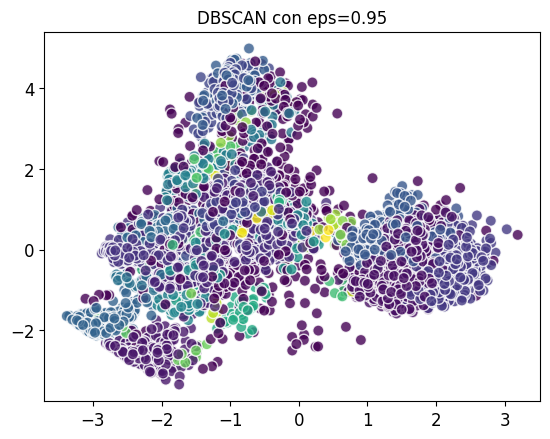

eps=1.2 → clusters: 51, puntos de ruido: 290


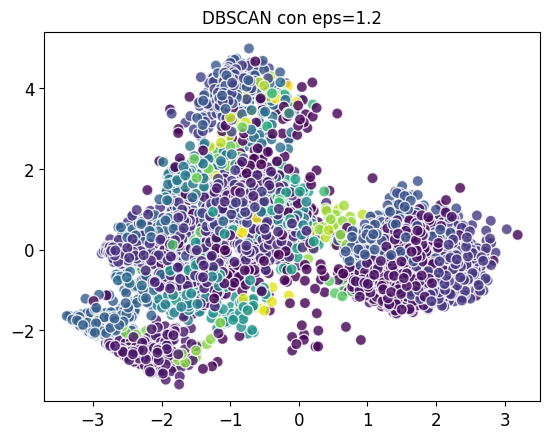

eps=1.5 → clusters: 53, puntos de ruido: 166


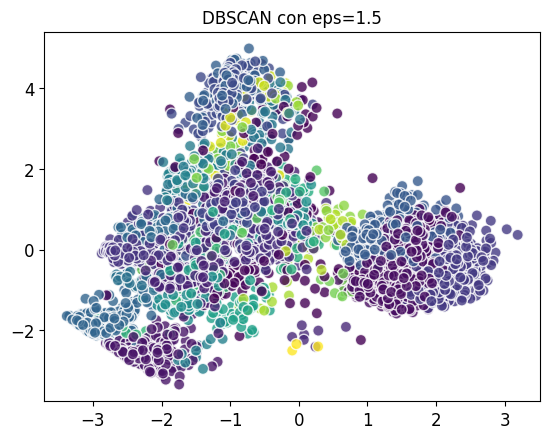

In [ ]:
eps_values = [0.95, 1.2, 1.5] 
min_samples = 5

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)
    
    print(f"eps={eps} → clusters: {n_clusters}, puntos de ruido: {n_noise}")
    
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=64, alpha=0.8, edgecolors='white')
    plt.title(f"DBSCAN con eps={eps}")
    plt.show()



Al usar eps = 1.5, DBSCAN logra reducir significativamente el ruido (208 puntos de ruido frente a miles en pruebas anteriores) y agrupa mejor los puntos densos en clusters. Sin embargo, el número de clusters sigue siendo mucho mayor que los 3 clusters detectados por K-Means (52 clusters frente a 3).

Nos podemos plantear cambier el numero de min_samples pero:
- Si subes min_samples, el número de clusters podría disminuir ligeramente, pero el número de puntos de ruido aumentará.

- Si bajas min_samples, el número de clusters podría aumentar, pero habrá menos ruido.

Para visualizar ese fenomeno vamos a verlo graficamente:


--- min_samples = 3 ---
eps=0.95 → clusters: 79, puntos de ruido: 355


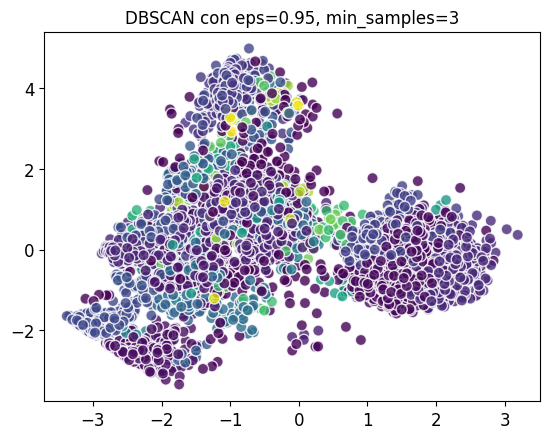

eps=1.2 → clusters: 65, puntos de ruido: 201


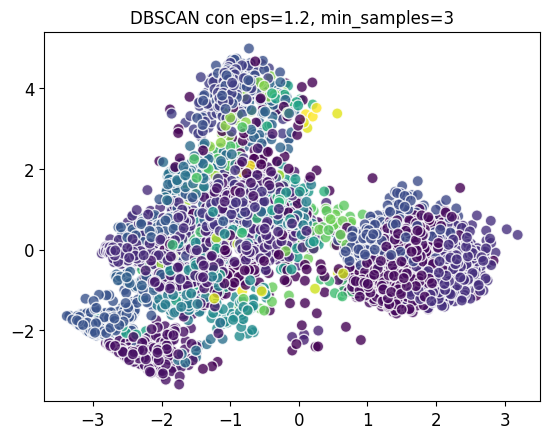

eps=1.5 → clusters: 66, puntos de ruido: 105


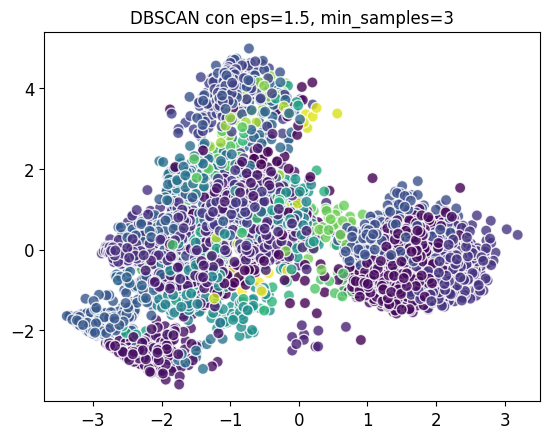


--- min_samples = 5 ---
eps=0.95 → clusters: 48, puntos de ruido: 550


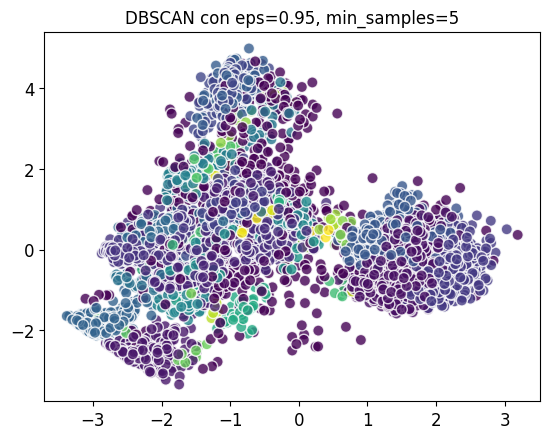

eps=1.2 → clusters: 51, puntos de ruido: 290


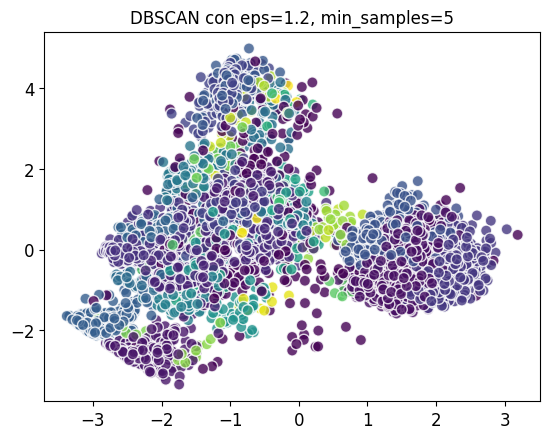

eps=1.5 → clusters: 53, puntos de ruido: 166


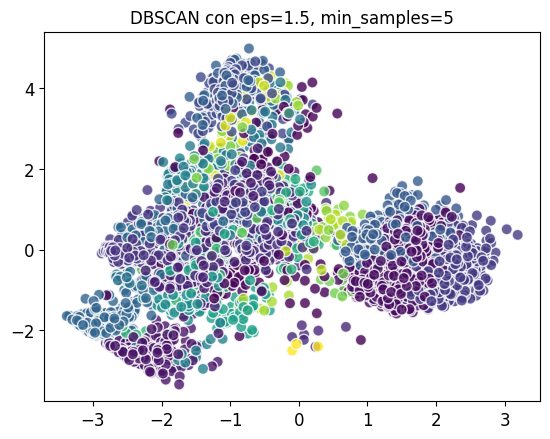


--- min_samples = 8 ---
eps=0.95 → clusters: 34, puntos de ruido: 735


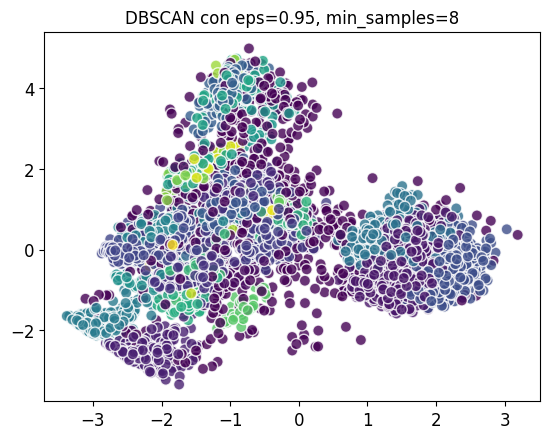

eps=1.2 → clusters: 37, puntos de ruido: 453


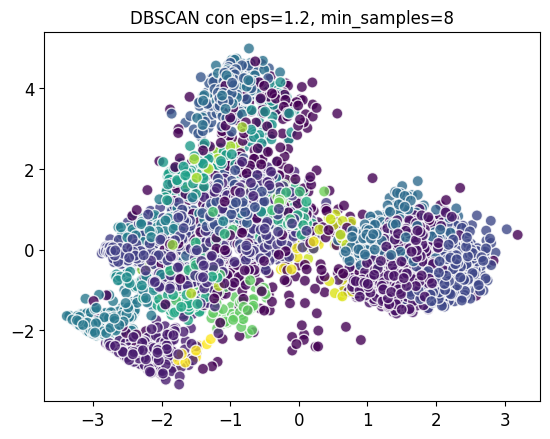

eps=1.5 → clusters: 42, puntos de ruido: 260


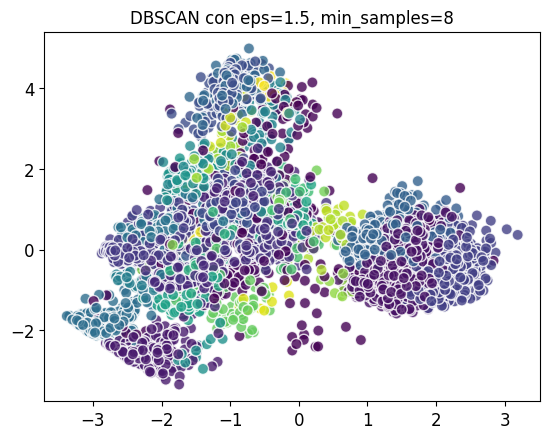

In [ ]:
eps_values = [0.95, 1.2, 1.5]
min_samples_values = [3, 5, 8]
for min_samples in min_samples_values:
    print(f"\n--- min_samples = {min_samples} ---")
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)
        
        print(f"eps={eps} → clusters: {n_clusters}, puntos de ruido: {n_noise}")
        
        plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=64, alpha=0.8, edgecolors='white')
        plt.title(f"DBSCAN con eps={eps}, min_samples={min_samples}")
        plt.show()


En general, para reducir el ruido conviene aumentar eps, y para detectar clusters significativos conviene aumentar min_samples, pero no es posible que DBSCAN reproduzca exactamente el resultado de K-Means debido a su naturaleza basada en densidad.

## 5. Gaussian Mixture Models